# All the Imports

In [1]:
import sys
import os
import logging
sys.path.insert(1, '../src/')

In [2]:
%%time 
import itertools 
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import LabelEncoder
from lassonet import LassoNetClassifier


from RankCorr.picturedRocks import Rocks
import smashpy as smashpy


import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F

from utils import *

CPU times: user 7.23 s, sys: 882 ms, total: 8.11 s
Wall time: 12.8 s


In [3]:
logging.getLogger("lightning").setLevel(logging.ERROR)
pl_loggers = [ logging.getLogger(name) for name in logging.root.manager.loggerDict if 'lightning' in name ]

for logger in pl_loggers:
    logger.setLevel(logging.ERROR)
    
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

# These should be parameters later on 

In [4]:
z_size = 16
hidden_layer_size = 256

# really good results for vanilla VAE on synthetic data with EPOCHS set to 50, 
# but when running locally set to 10 for reasonable run times
batch_size = 64
batch_norm = True


global_t = 3.0

k_range = [10, 50, 100, 250]
k = 50
num_times = 10

#pytorch lightning stuff
gpus = 1
tpu_cores = None
precision=32

# The smashpy methods set global seeds that mess with sampling. These seeds are used 
# to stop those methods from using the same global seed over and over.
possible_seeds = np.random.randint(low=1, high = 1000000, size = 400)
seed_index = 0

In [5]:
import multiprocessing

num_cores = multiprocessing.cpu_count()

In [6]:
torch.cuda.is_available()

True

# Here goes all the stuff that we change from dataset to dataset

In [7]:
from os import path

In [8]:
dataset_dir = '../data/zeisel/'
model_save_path = '../data/zeisel/models/'
viz_save_path = '../data/zeisel/visualizations/'

if not path.exists(model_save_path):
  os.makedirs(model_save_path)

if not path.exists(model_save_path + 'experiment_data_folds/'):
  os.makedirs(model_save_path + 'experiment_data_folds/')
  
if not path.exists(viz_save_path):
  os.makedirs(viz_save_path)

  

# Dataset Specific Processing

`

In [9]:
adata = sc.read_h5ad(dataset_dir + "Zeisel.h5ad")

In [10]:
adata.obs

names0 names1 labels0 labels1
0          interneurons  Int10       3      12
1          interneurons  Int10       3      12
2          interneurons   Int6       3      23
3          interneurons  Int10       3      12
4          interneurons   Int9       3      26
...                 ...    ...     ...     ...
3000  endothelial-mural  Peric       2      35
3001  endothelial-mural   Vsmc       2      48
3002  endothelial-mural   Vsmc       2      48
3003  endothelial-mural   Vsmc       2      48
3004  endothelial-mural   Vsmc       2      48

[3005 rows x 4 columns]

In [11]:
adata.shape

(3005, 4000)

In [12]:
np.apply_along_axis(np.mean, 0, adata.X)

array([5.07780e-09, 4.06224e-08, 0.00000e+00, ..., 4.06224e-08,
       3.04668e-08, 0.00000e+00], dtype=float32)

In [13]:
np.apply_along_axis(np.var, 0, adata.X)

array([0.9996673, 0.9996672, 0.9996674, ..., 0.9996672, 0.9996674,
       0.9996673], dtype=float32)

In [14]:
X = adata.X.copy()
adata.obs['names']=adata.obs['names0']
adata.obs['annotation'] = adata.obs['names0']
labels = adata.obs['names0'].values
encoder = LabelEncoder()
encoder.fit(labels)
y = encoder.transform(labels)

In [15]:
input_size = X.shape[1]
y

array([2, 2, 2, ..., 1, 1, 1])

# Set Up Models

## Baseline

In [16]:
%%time
for tryy in range(1,num_times+1):
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    all_markers = np.arange(X.shape[1])
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = all_markers)
    np.save(model_save_path + 'all_markers_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'all_markers_{}.npy'.format(tryy), all_markers)
    np.save(model_save_path + 'experiment_data_folds/all_markers_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'All Marker Visualization', path = viz_save_path + 'all_markers_{}.pdf'.format(tryy), markers = all_markers)


CPU times: user 4min 16s, sys: 4.3 s, total: 4min 20s
Wall time: 2min 45s


## Train Smash Random Forest





In [17]:
# needed for random forest Smash
!mkdir Figures

mkdir: cannot create directory ‘Figures’: File exists


 * Initialising ...

Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

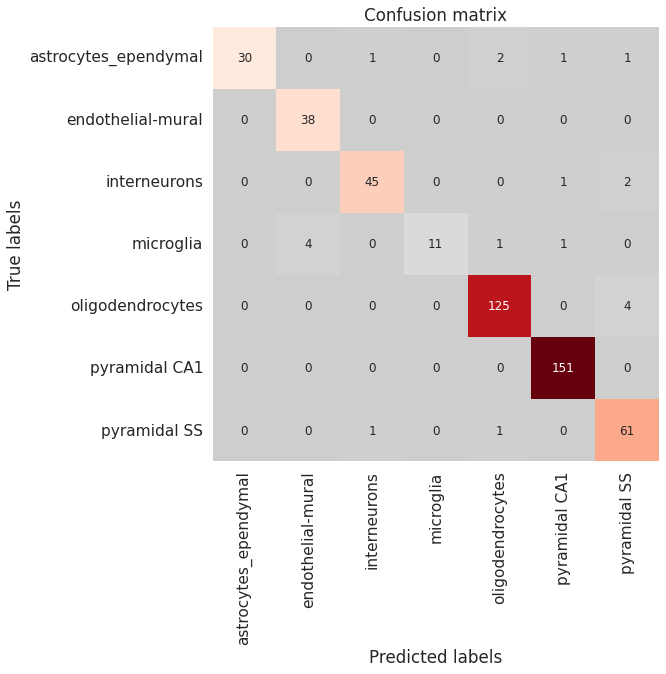

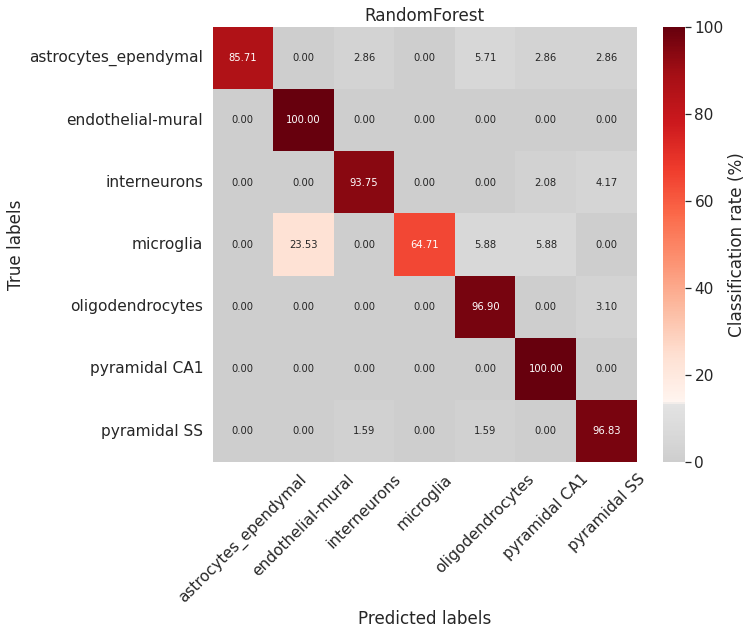

Accuracy: 0.9584199584199584: Misclassification: 0.04158004158004158
                      precision    recall  f1-score   support

astrocytes_ependymal       1.00      0.86      0.92        35
   endothelial-mural       0.90      1.00      0.95        38
        interneurons       0.96      0.94      0.95        48
           microglia       1.00      0.65      0.79        17
    oligodendrocytes       0.97      0.97      0.97       129
       pyramidal CA1       0.98      1.00      0.99       151
        pyramidal SS       0.90      0.97      0.93        63

            accuracy                           0.96       481
           macro avg       0.96      0.91      0.93       481
        weighted avg       0.96      0.96      0.96       481

 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

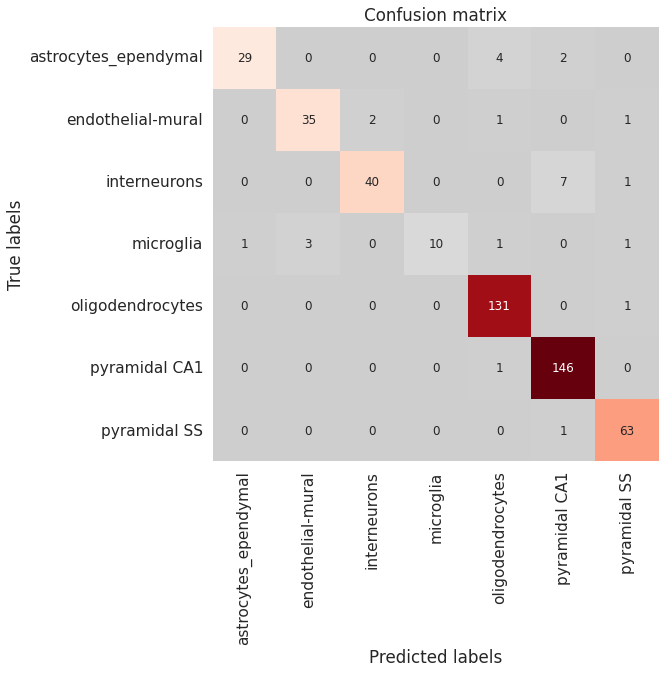

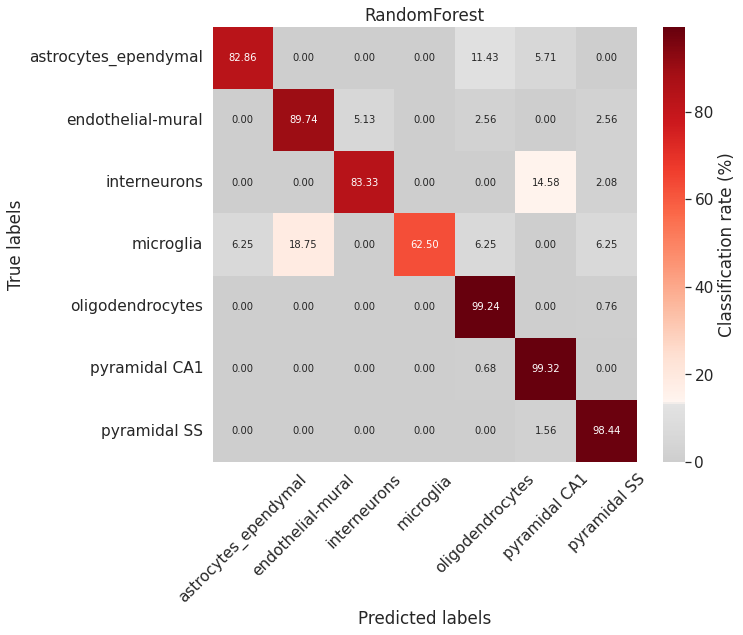

Accuracy: 0.9438669438669439: Misclassification: 0.05613305613305608
                      precision    recall  f1-score   support

astrocytes_ependymal       0.97      0.83      0.89        35
   endothelial-mural       0.92      0.90      0.91        39
        interneurons       0.95      0.83      0.89        48
           microglia       1.00      0.62      0.77        16
    oligodendrocytes       0.95      0.99      0.97       132
       pyramidal CA1       0.94      0.99      0.96       147
        pyramidal SS       0.94      0.98      0.96        64

            accuracy                           0.94       481
           macro avg       0.95      0.88      0.91       481
        weighted avg       0.94      0.94      0.94       481

 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

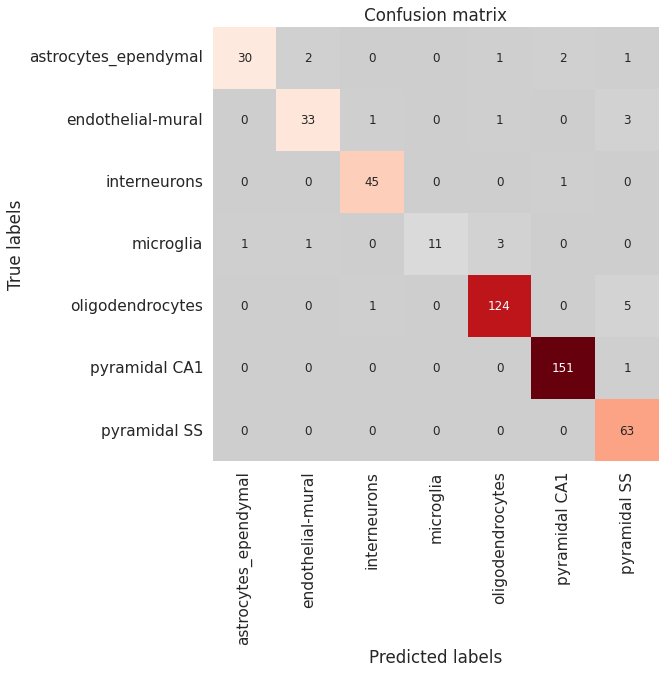

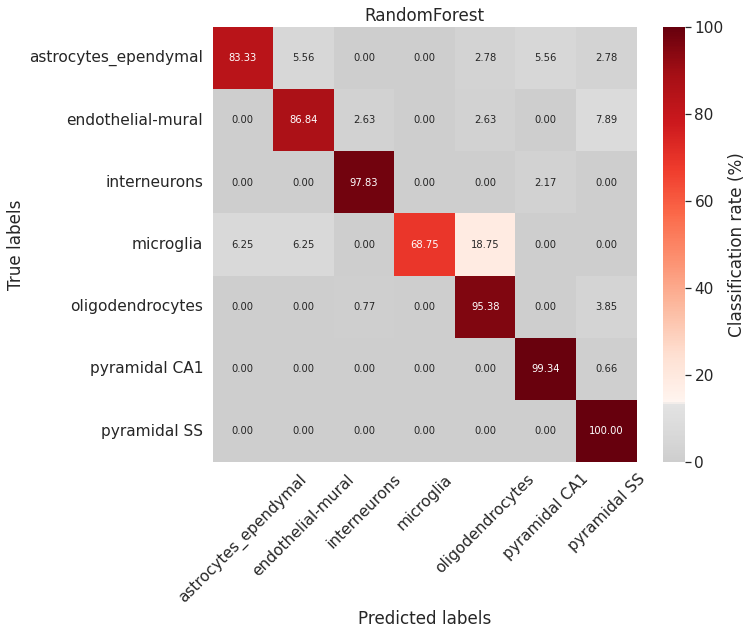

Accuracy: 0.9501039501039501: Misclassification: 0.0498960498960499
                      precision    recall  f1-score   support

astrocytes_ependymal       0.97      0.83      0.90        36
   endothelial-mural       0.92      0.87      0.89        38
        interneurons       0.96      0.98      0.97        46
           microglia       1.00      0.69      0.81        16
    oligodendrocytes       0.96      0.95      0.96       130
       pyramidal CA1       0.98      0.99      0.99       152
        pyramidal SS       0.86      1.00      0.93        63

            accuracy                           0.95       481
           macro avg       0.95      0.90      0.92       481
        weighted avg       0.95      0.95      0.95       481

 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

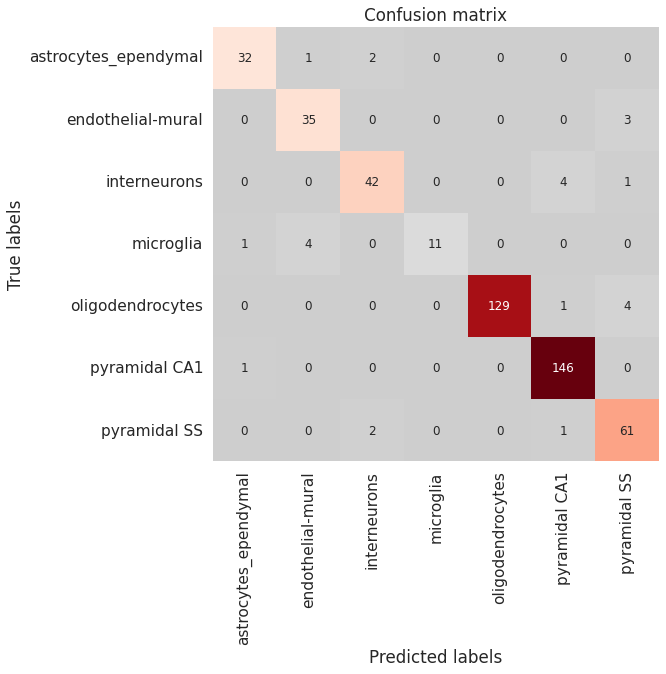

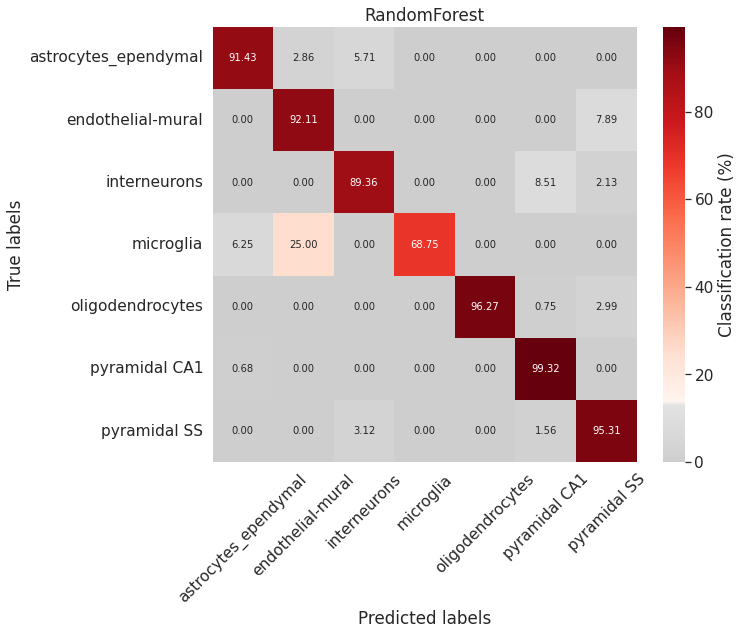

Accuracy: 0.9480249480249481: Misclassification: 0.05197505197505192
                      precision    recall  f1-score   support

astrocytes_ependymal       0.94      0.91      0.93        35
   endothelial-mural       0.88      0.92      0.90        38
        interneurons       0.91      0.89      0.90        47
           microglia       1.00      0.69      0.81        16
    oligodendrocytes       1.00      0.96      0.98       134
       pyramidal CA1       0.96      0.99      0.98       147
        pyramidal SS       0.88      0.95      0.92        64

            accuracy                           0.95       481
           macro avg       0.94      0.90      0.92       481
        weighted avg       0.95      0.95      0.95       481

 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

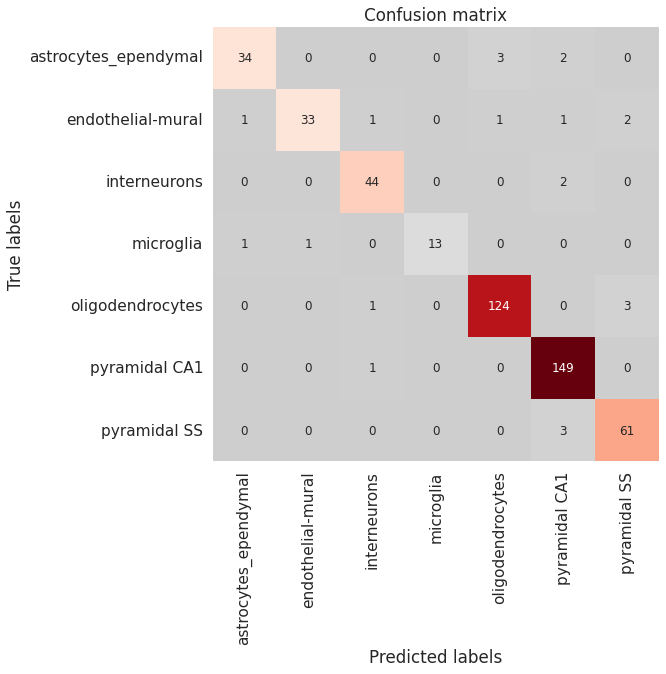

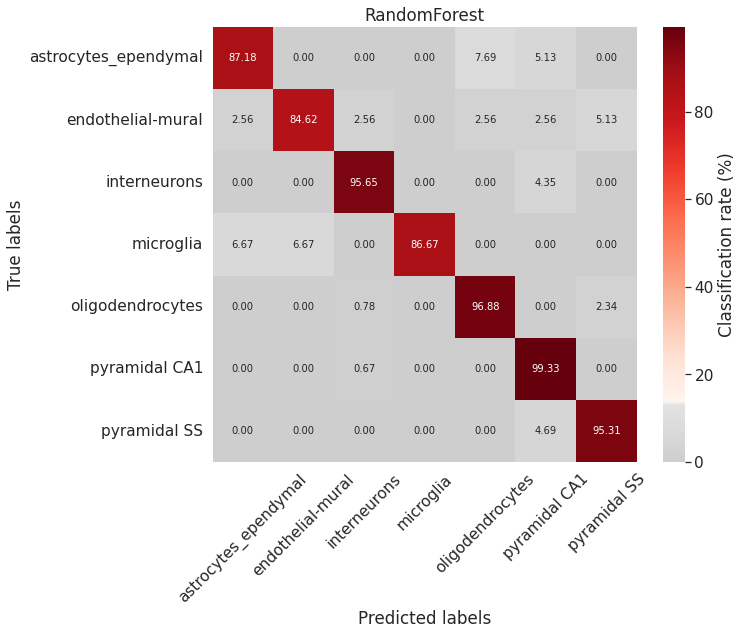

Accuracy: 0.9521829521829522: Misclassification: 0.047817047817047764
                      precision    recall  f1-score   support

astrocytes_ependymal       0.94      0.87      0.91        39
   endothelial-mural       0.97      0.85      0.90        39
        interneurons       0.94      0.96      0.95        46
           microglia       1.00      0.87      0.93        15
    oligodendrocytes       0.97      0.97      0.97       128
       pyramidal CA1       0.95      0.99      0.97       150
        pyramidal SS       0.92      0.95      0.94        64

            accuracy                           0.95       481
           macro avg       0.96      0.92      0.94       481
        weighted avg       0.95      0.95      0.95       481

 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

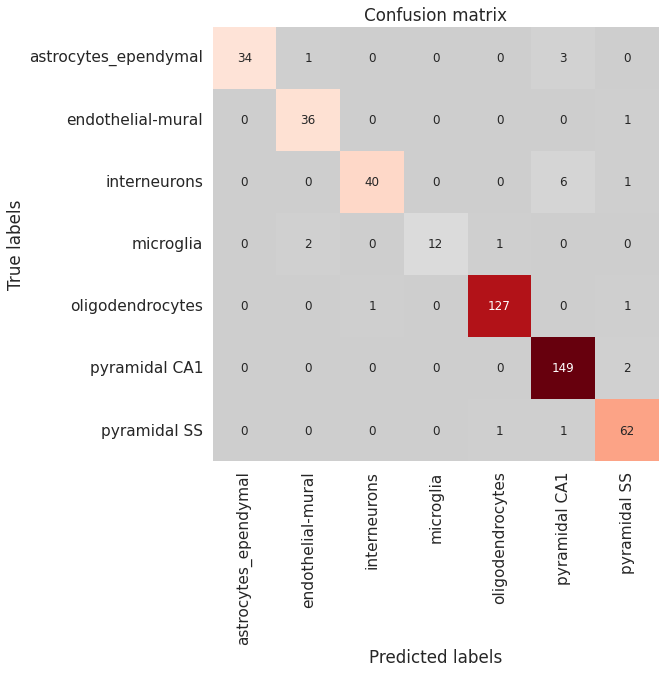

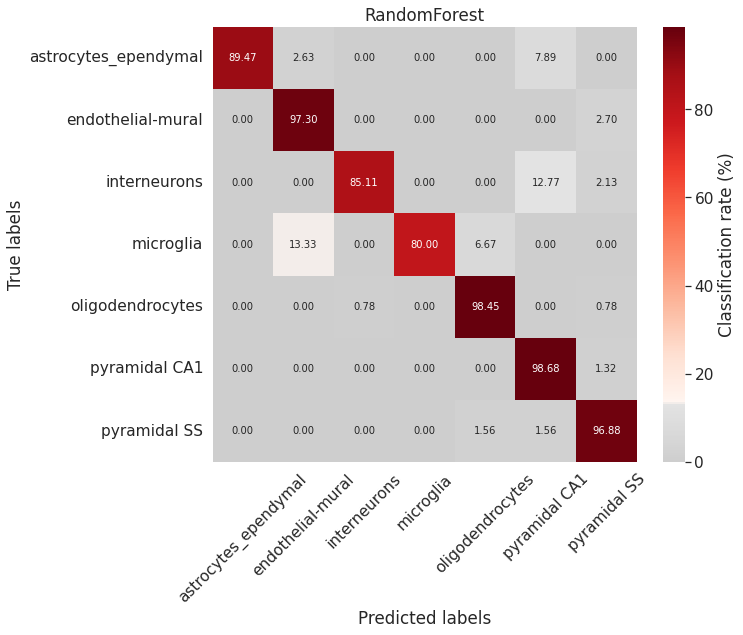

Accuracy: 0.9563409563409564: Misclassification: 0.043659043659043606
                      precision    recall  f1-score   support

astrocytes_ependymal       1.00      0.89      0.94        38
   endothelial-mural       0.92      0.97      0.95        37
        interneurons       0.98      0.85      0.91        47
           microglia       1.00      0.80      0.89        15
    oligodendrocytes       0.98      0.98      0.98       129
       pyramidal CA1       0.94      0.99      0.96       151
        pyramidal SS       0.93      0.97      0.95        64

            accuracy                           0.96       481
           macro avg       0.96      0.92      0.94       481
        weighted avg       0.96      0.96      0.96       481

 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

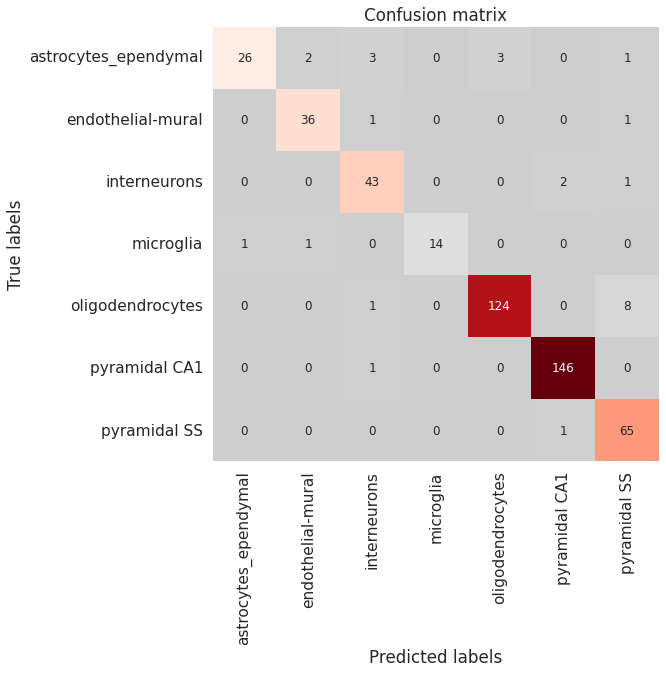

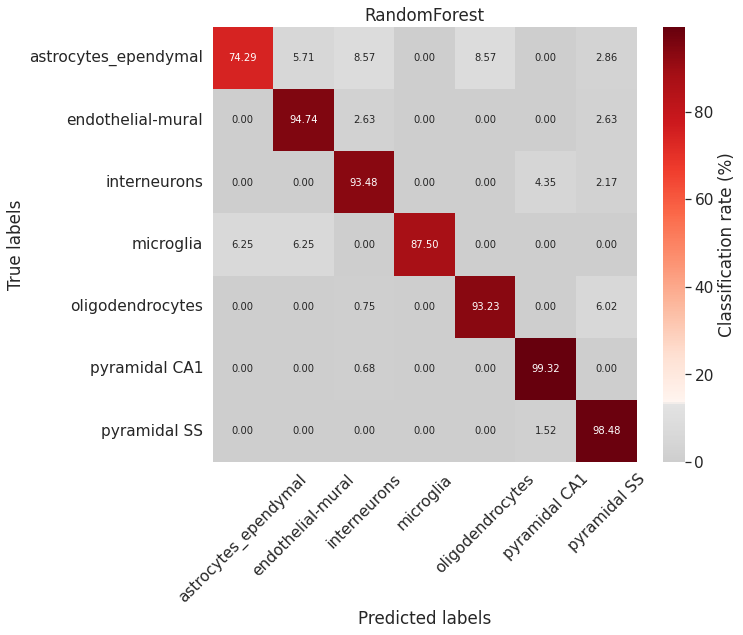

Accuracy: 0.9438669438669439: Misclassification: 0.05613305613305608
                      precision    recall  f1-score   support

astrocytes_ependymal       0.96      0.74      0.84        35
   endothelial-mural       0.92      0.95      0.94        38
        interneurons       0.88      0.93      0.91        46
           microglia       1.00      0.88      0.93        16
    oligodendrocytes       0.98      0.93      0.95       133
       pyramidal CA1       0.98      0.99      0.99       147
        pyramidal SS       0.86      0.98      0.92        66

            accuracy                           0.94       481
           macro avg       0.94      0.92      0.92       481
        weighted avg       0.95      0.94      0.94       481

 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

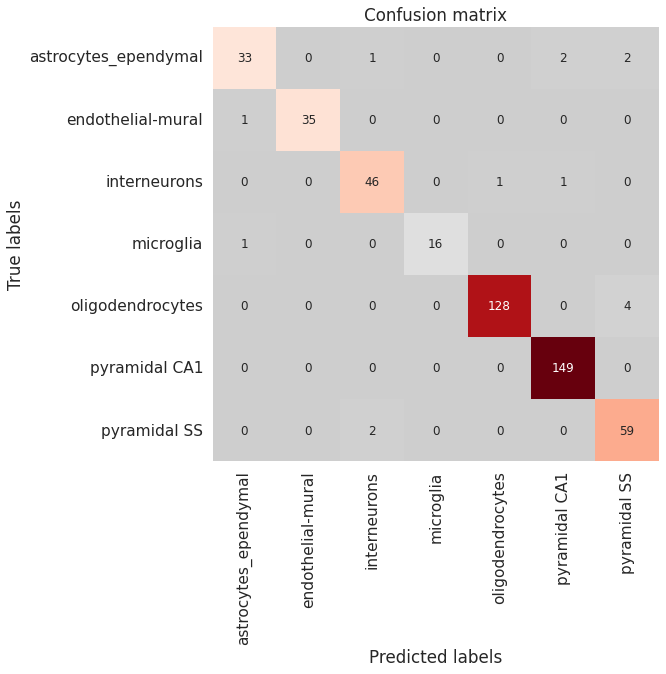

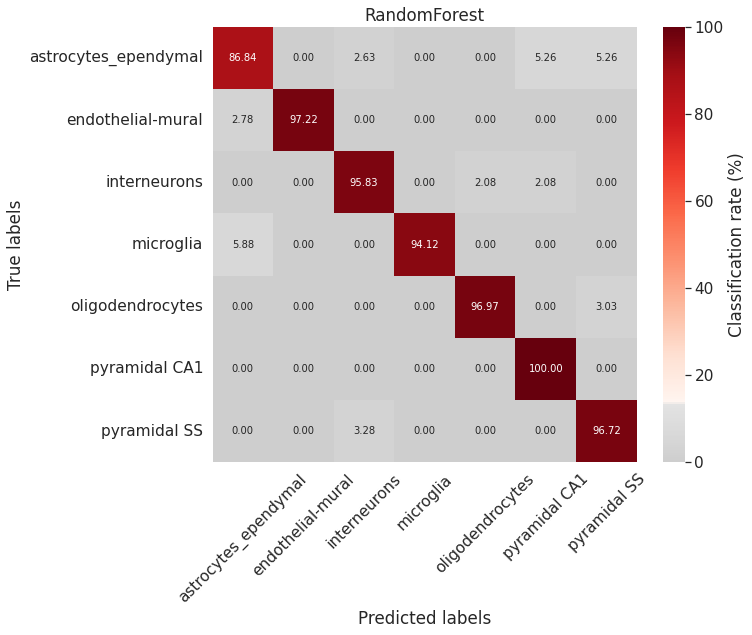

Accuracy: 0.9688149688149689: Misclassification: 0.03118503118503113
                      precision    recall  f1-score   support

astrocytes_ependymal       0.94      0.87      0.90        38
   endothelial-mural       1.00      0.97      0.99        36
        interneurons       0.94      0.96      0.95        48
           microglia       1.00      0.94      0.97        17
    oligodendrocytes       0.99      0.97      0.98       132
       pyramidal CA1       0.98      1.00      0.99       149
        pyramidal SS       0.91      0.97      0.94        61

            accuracy                           0.97       481
           macro avg       0.97      0.95      0.96       481
        weighted avg       0.97      0.97      0.97       481

 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

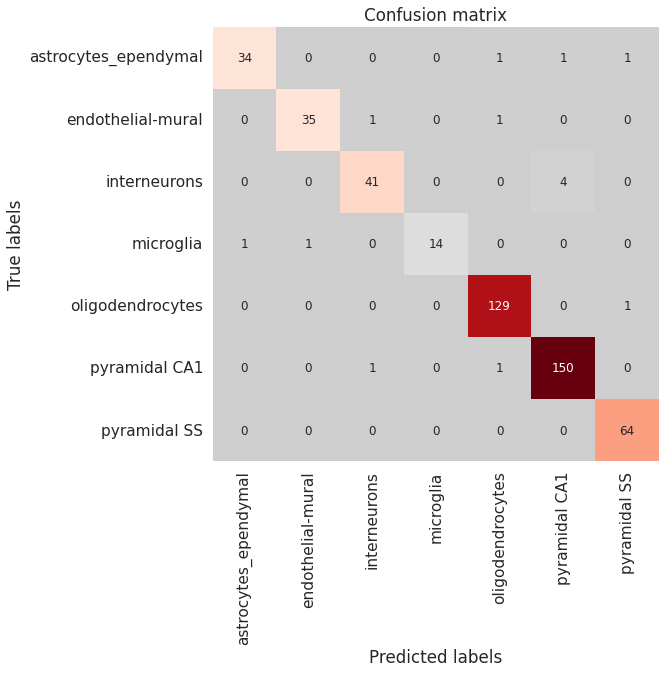

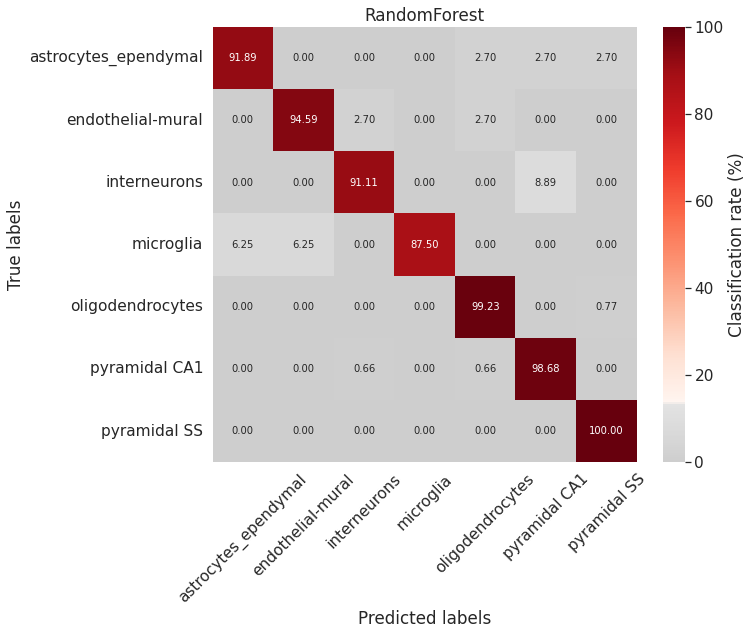

Accuracy: 0.9708939708939709: Misclassification: 0.029106029106029108
                      precision    recall  f1-score   support

astrocytes_ependymal       0.97      0.92      0.94        37
   endothelial-mural       0.97      0.95      0.96        37
        interneurons       0.95      0.91      0.93        45
           microglia       1.00      0.88      0.93        16
    oligodendrocytes       0.98      0.99      0.98       130
       pyramidal CA1       0.97      0.99      0.98       152
        pyramidal SS       0.97      1.00      0.98        64

            accuracy                           0.97       481
           macro avg       0.97      0.95      0.96       481
        weighted avg       0.97      0.97      0.97       481

 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

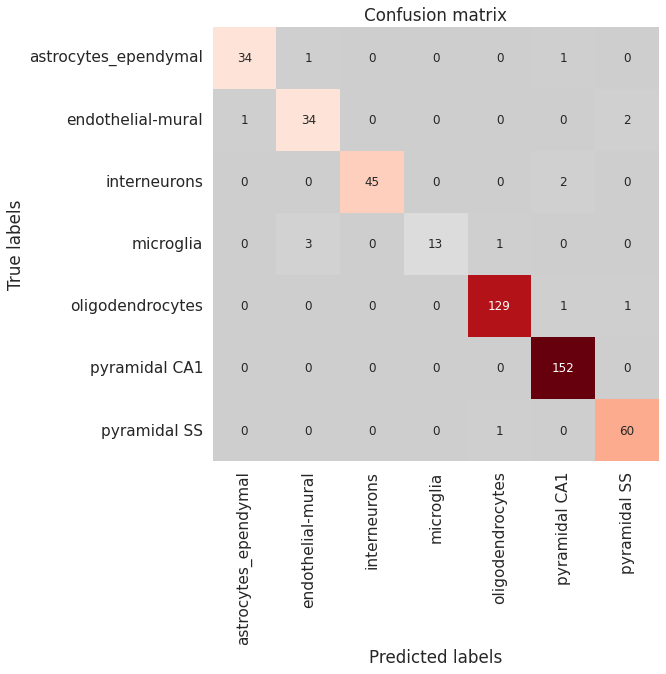

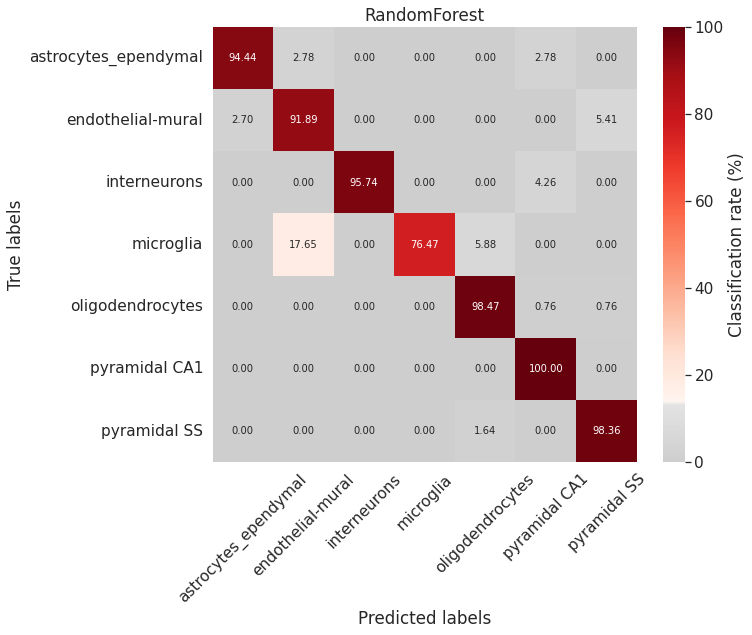

Accuracy: 0.9708939708939709: Misclassification: 0.029106029106029108
                      precision    recall  f1-score   support

astrocytes_ependymal       0.97      0.94      0.96        36
   endothelial-mural       0.89      0.92      0.91        37
        interneurons       1.00      0.96      0.98        47
           microglia       1.00      0.76      0.87        17
    oligodendrocytes       0.98      0.98      0.98       131
       pyramidal CA1       0.97      1.00      0.99       152
        pyramidal SS       0.95      0.98      0.97        61

            accuracy                           0.97       481
           macro avg       0.97      0.94      0.95       481
        weighted avg       0.97      0.97      0.97       481

CPU times: user 3min 22s, sys: 6.45 s, total: 3min 29s
Wall time: 1min 56s


In [18]:
%%time
for tryy in range(1,num_times+1):
    # The smashpy methods set global seeds that mess with sampling. These seeds are used 
    # to stop those methods from using the same global seed over and over.
    np.random.seed(possible_seeds[seed_index])
    seed_index += 1
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    train_X_y = adata[np.concatenate([train_indices, val_indices]), :]
    sm = smashpy.smashpy()
    clf = sm.ensemble_learning(train_X_y, group_by="annotation", classifier="RandomForest", balance=True, verbose=True)
    selectedGenes, selectedGenes_dict = sm.gini_importance(train_X_y, clf, group_by="annotation", verbose=True, restrict_top=("global", k))
    # since this selects k per class, need select randomly from each classes
    smash_markers = adata.var.index.get_indexer(selectedGenes)

    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = smash_markers)
    np.save(model_save_path + 'smash_rf_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'smash_rf_markers_{}.npy'.format(tryy), smash_markers)
    np.save(model_save_path + 'experiment_data_folds/smash_rf_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Smash Random Forest Marker Visualization', path = viz_save_path + 'smash_rf_markers_{}.png'.format(tryy), markers = smash_markers)

## Train Smash DNN

the data is treated a bit differently than our other models

 * Initialising ...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                128032    
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
activation (Activation)      (None, 32)                0         
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
activation_1 (Activation)    (None, 

20/20 [==============================] - 0s 4ms/step - loss: 0.7169 - accuracy: 0.9308 - auc: 0.9948 - precision: 0.9988 - recall: 0.4379 - val_loss: 0.7792 - val_accuracy: 0.9501 - val_auc: 0.9966 - val_precision: 1.0000 - val_recall: 0.4241

Epoch 00018: val_loss improved from 0.80864 to 0.77924, saving model to weights/best_model_annotation.h5
Epoch 19/100
20/20 [==============================] - 0s 4ms/step - loss: 0.6835 - accuracy: 0.9407 - auc: 0.9966 - precision: 0.9989 - recall: 0.4883 - val_loss: 0.7537 - val_accuracy: 0.9480 - val_auc: 0.9968 - val_precision: 1.0000 - val_recall: 0.4615

Epoch 00019: val_loss improved from 0.77924 to 0.75374, saving model to weights/best_model_annotation.h5
Epoch 20/100
20/20 [==============================] - 0s 4ms/step - loss: 0.6484 - accuracy: 0.9496 - auc: 0.9968 - precision: 1.0000 - recall: 0.5299 - val_loss: 0.7243 - val_accuracy: 0.9522 - val_auc: 0.9969 - val_precision: 0.9961 - val_recall: 0.5364

Epoch 00020: val_loss improved f


Epoch 00041: val_loss did not improve from 0.35373
Epoch 42/100
20/20 [==============================] - 0s 4ms/step - loss: 0.2530 - accuracy: 0.9912 - auc: 0.9998 - precision: 0.9994 - recall: 0.9371 - val_loss: 0.3497 - val_accuracy: 0.9584 - val_auc: 0.9974 - val_precision: 0.9841 - val_recall: 0.9023

Epoch 00042: val_loss improved from 0.35373 to 0.34974, saving model to weights/best_model_annotation.h5
Epoch 43/100
20/20 [==============================] - 0s 4ms/step - loss: 0.2498 - accuracy: 0.9849 - auc: 0.9997 - precision: 0.9955 - recall: 0.9267 - val_loss: 0.3680 - val_accuracy: 0.9376 - val_auc: 0.9964 - val_precision: 0.9771 - val_recall: 0.8857

Epoch 00043: val_loss did not improve from 0.34974
Epoch 44/100
20/20 [==============================] - 0s 3ms/step - loss: 0.2396 - accuracy: 0.9870 - auc: 0.9998 - precision: 0.9972 - recall: 0.9262 - val_loss: 0.3144 - val_accuracy: 0.9563 - val_auc: 0.9973 - val_precision: 0.9801 - val_recall: 0.9210

Epoch 00044: val_loss


Epoch 00066: val_loss did not improve from 0.22535
Epoch 67/100
20/20 [==============================] - 0s 4ms/step - loss: 0.1104 - accuracy: 0.9964 - auc: 1.0000 - precision: 0.9989 - recall: 0.9870 - val_loss: 0.2353 - val_accuracy: 0.9480 - val_auc: 0.9972 - val_precision: 0.9632 - val_recall: 0.9252

Epoch 00067: val_loss did not improve from 0.22535
Epoch 68/100
20/20 [==============================] - 0s 4ms/step - loss: 0.1056 - accuracy: 0.9974 - auc: 1.0000 - precision: 0.9989 - recall: 0.9860 - val_loss: 0.2293 - val_accuracy: 0.9501 - val_auc: 0.9970 - val_precision: 0.9653 - val_recall: 0.9252

Epoch 00068: val_loss did not improve from 0.22535
Epoch 00068: early stopping


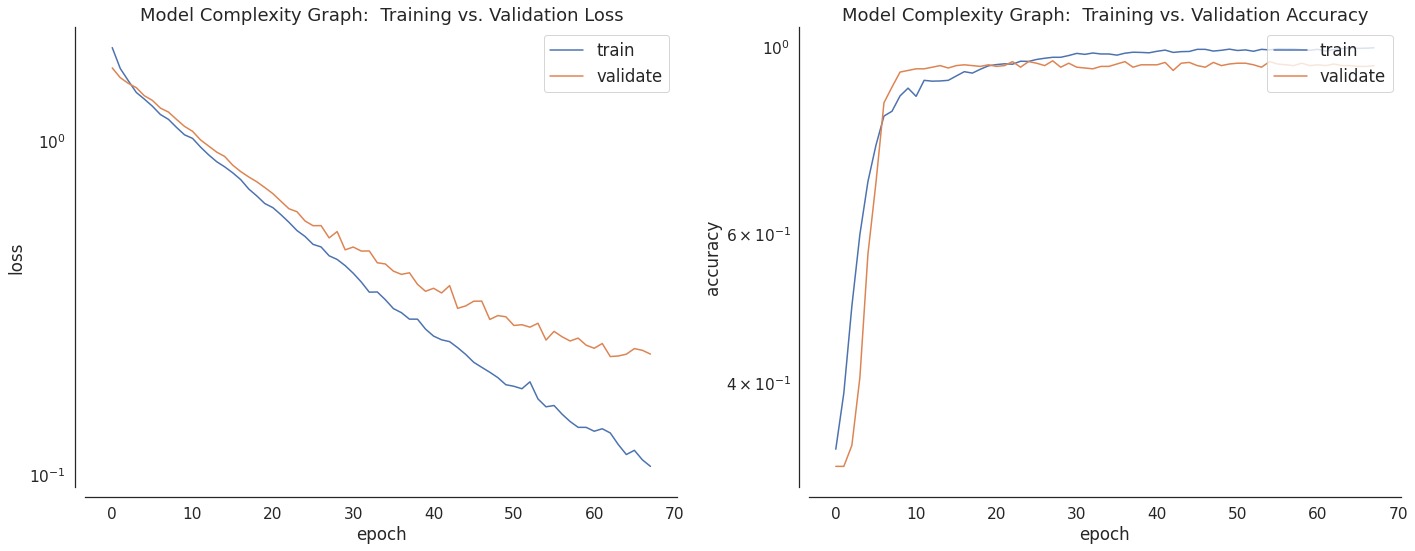

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

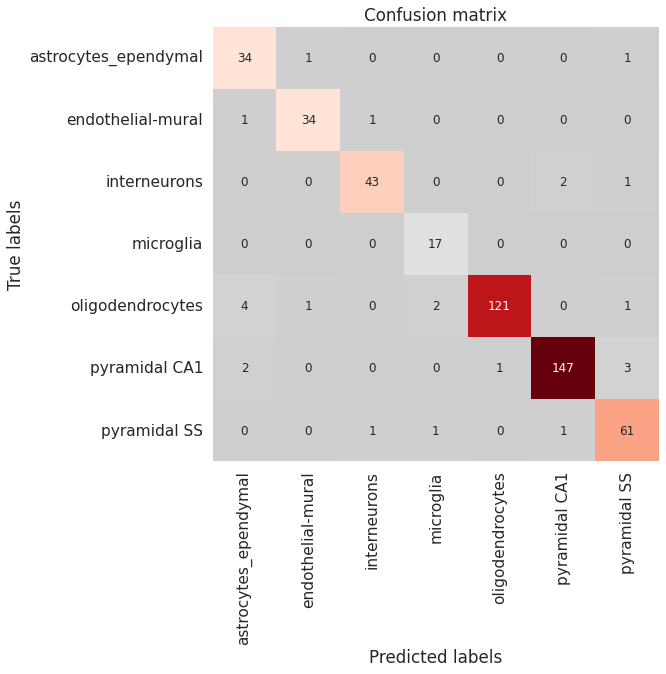

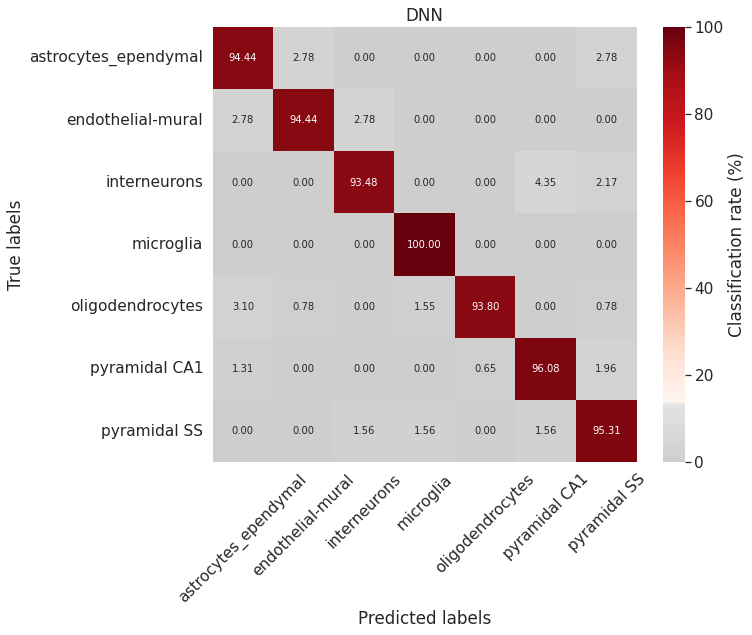

                      precision    recall  f1-score   support

astrocytes_ependymal       0.83      0.94      0.88        36
   endothelial-mural       0.94      0.94      0.94        36
        interneurons       0.96      0.93      0.95        46
           microglia       0.85      1.00      0.92        17
    oligodendrocytes       0.99      0.94      0.96       129
       pyramidal CA1       0.98      0.96      0.97       153
        pyramidal SS       0.91      0.95      0.93        64

            accuracy                           0.95       481
           macro avg       0.92      0.95      0.94       481
        weighted avg       0.95      0.95      0.95       481

16/16 [==============================] - 0s 1ms/step - loss: 0.2253 - accuracy: 0.9543 - auc: 0.9977 - precision: 0.9716 - recall: 0.9231


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


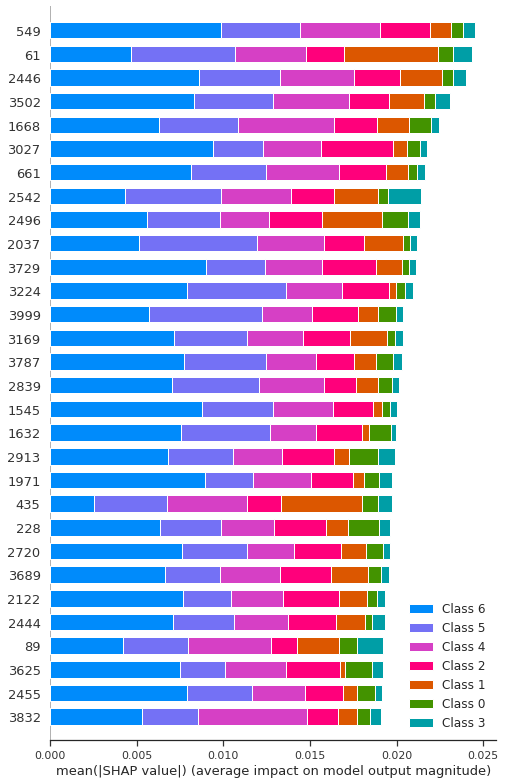

 * Initialising ...
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 32)                128032    
_________________________________________________________________
batch_normalization_4 (Batch (None, 32)                128       
_________________________________________________________________
activation_4 (Activation)    (None, 32)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                528       
_________________________________________________________________
batch_normalization_5 (Batch (None, 16)                64        
_________________________________________________________________
activation_5 (Activation)    (None

20/20 [==============================] - 0s 4ms/step - loss: 0.6714 - accuracy: 0.9459 - auc: 0.9964 - precision: 1.0000 - recall: 0.5049 - val_loss: 0.7356 - val_accuracy: 0.9522 - val_auc: 0.9978 - val_precision: 0.9958 - val_recall: 0.4906

Epoch 00019: val_loss improved from 0.75109 to 0.73557, saving model to weights/best_model_annotation.h5
Epoch 20/100
20/20 [==============================] - 0s 4ms/step - loss: 0.6568 - accuracy: 0.9459 - auc: 0.9972 - precision: 0.9990 - recall: 0.5299 - val_loss: 0.6863 - val_accuracy: 0.9563 - val_auc: 0.9978 - val_precision: 0.9965 - val_recall: 0.5842

Epoch 00020: val_loss improved from 0.73557 to 0.68630, saving model to weights/best_model_annotation.h5
Epoch 21/100
20/20 [==============================] - 0s 4ms/step - loss: 0.6226 - accuracy: 0.9511 - auc: 0.9970 - precision: 0.9991 - recall: 0.5725 - val_loss: 0.6907 - val_accuracy: 0.9418 - val_auc: 0.9971 - val_precision: 0.9929 - val_recall: 0.5821

Epoch 00021: val_loss did not im

20/20 [==============================] - 0s 4ms/step - loss: 0.2432 - accuracy: 0.9875 - auc: 0.9998 - precision: 0.9989 - recall: 0.9412 - val_loss: 0.3141 - val_accuracy: 0.9605 - val_auc: 0.9984 - val_precision: 0.9801 - val_recall: 0.9231

Epoch 00042: val_loss improved from 0.31772 to 0.31406, saving model to weights/best_model_annotation.h5
Epoch 43/100
20/20 [==============================] - 0s 4ms/step - loss: 0.2492 - accuracy: 0.9880 - auc: 0.9998 - precision: 0.9989 - recall: 0.9340 - val_loss: 0.3264 - val_accuracy: 0.9584 - val_auc: 0.9982 - val_precision: 0.9800 - val_recall: 0.9168

Epoch 00043: val_loss did not improve from 0.31406
Epoch 44/100
20/20 [==============================] - 0s 3ms/step - loss: 0.2285 - accuracy: 0.9880 - auc: 0.9999 - precision: 0.9995 - recall: 0.9496 - val_loss: 0.2962 - val_accuracy: 0.9626 - val_auc: 0.9986 - val_precision: 0.9759 - val_recall: 0.9272

Epoch 00044: val_loss improved from 0.31406 to 0.29615, saving model to weights/best_m

20/20 [==============================] - 0s 4ms/step - loss: 0.1167 - accuracy: 0.9948 - auc: 1.0000 - precision: 0.9995 - recall: 0.9839 - val_loss: 0.1961 - val_accuracy: 0.9584 - val_auc: 0.9985 - val_precision: 0.9679 - val_recall: 0.9418

Epoch 00066: val_loss improved from 0.20161 to 0.19608, saving model to weights/best_model_annotation.h5
Epoch 67/100
20/20 [==============================] - 0s 4ms/step - loss: 0.1128 - accuracy: 0.9932 - auc: 1.0000 - precision: 0.9974 - recall: 0.9834 - val_loss: 0.1882 - val_accuracy: 0.9563 - val_auc: 0.9986 - val_precision: 0.9701 - val_recall: 0.9459

Epoch 00067: val_loss improved from 0.19608 to 0.18818, saving model to weights/best_model_annotation.h5
Epoch 68/100
20/20 [==============================] - 0s 4ms/step - loss: 0.1099 - accuracy: 0.9969 - auc: 1.0000 - precision: 0.9989 - recall: 0.9880 - val_loss: 0.1919 - val_accuracy: 0.9480 - val_auc: 0.9986 - val_precision: 0.9659 - val_recall: 0.9418

Epoch 00068: val_loss did not im


Epoch 00090: val_loss improved from 0.15650 to 0.15324, saving model to weights/best_model_annotation.h5
Epoch 91/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0728 - accuracy: 0.9969 - auc: 0.9999 - precision: 0.9995 - recall: 0.9922 - val_loss: 0.1461 - val_accuracy: 0.9522 - val_auc: 0.9985 - val_precision: 0.9600 - val_recall: 0.9480

Epoch 00091: val_loss improved from 0.15324 to 0.14605, saving model to weights/best_model_annotation.h5
Epoch 92/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0653 - accuracy: 0.9984 - auc: 1.0000 - precision: 0.9990 - recall: 0.9938 - val_loss: 0.1632 - val_accuracy: 0.9480 - val_auc: 0.9981 - val_precision: 0.9556 - val_recall: 0.9397

Epoch 00092: val_loss did not improve from 0.14605
Epoch 93/100
20/20 [==============================] - 0s 3ms/step - loss: 0.0615 - accuracy: 0.9990 - auc: 1.0000 - precision: 1.0000 - recall: 0.9948 - val_loss: 0.1644 - val_accuracy: 0.9522 - val_auc: 0.9980 - val_precisi

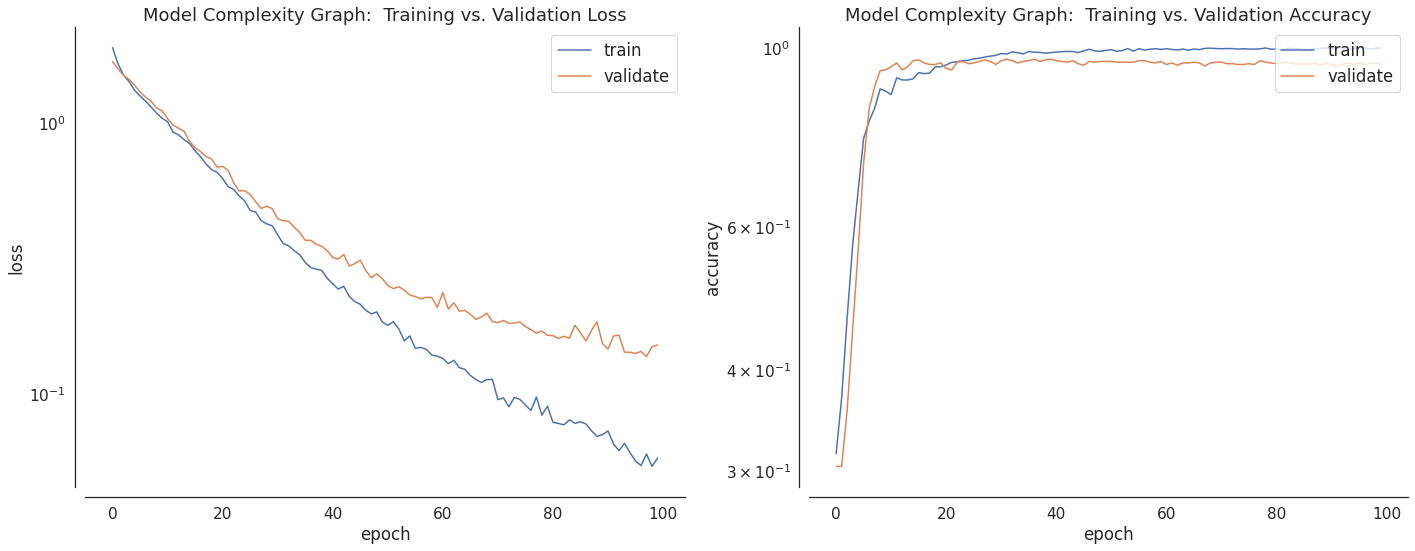

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

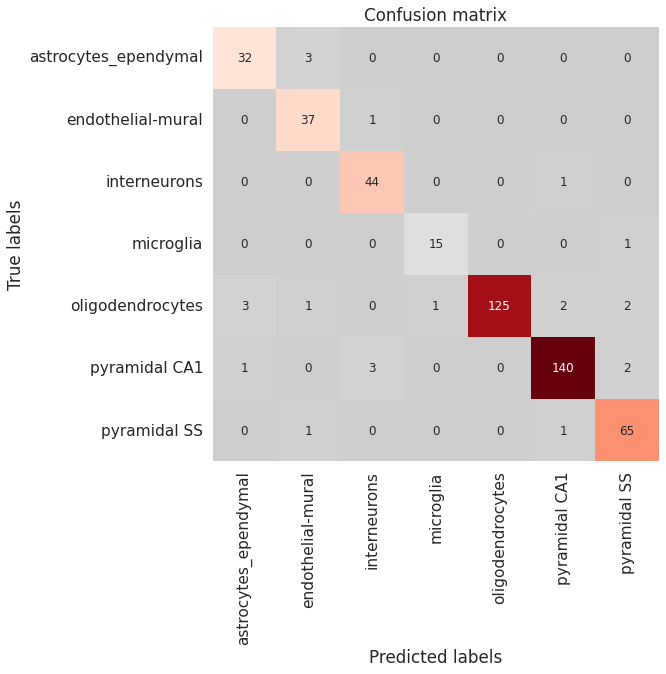

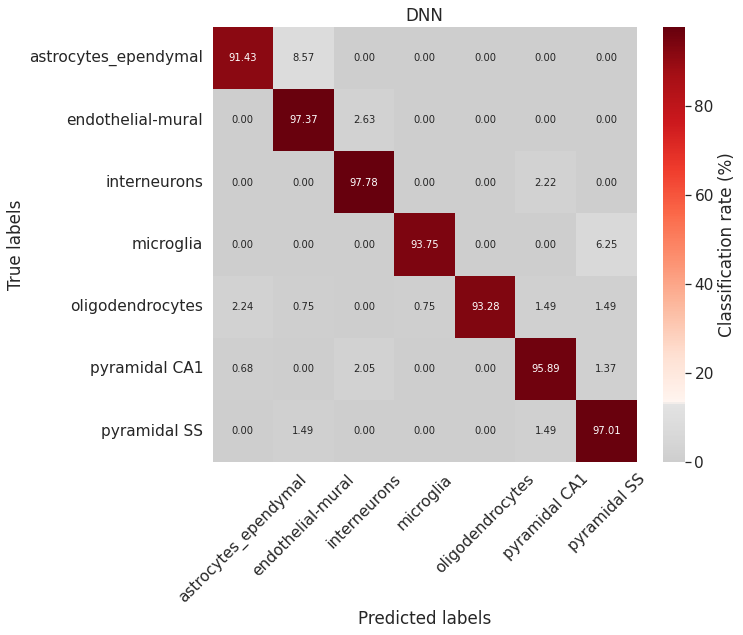

                      precision    recall  f1-score   support

astrocytes_ependymal       0.89      0.91      0.90        35
   endothelial-mural       0.88      0.97      0.93        38
        interneurons       0.92      0.98      0.95        45
           microglia       0.94      0.94      0.94        16
    oligodendrocytes       1.00      0.93      0.97       134
       pyramidal CA1       0.97      0.96      0.97       146
        pyramidal SS       0.93      0.97      0.95        67

            accuracy                           0.95       481
           macro avg       0.93      0.95      0.94       481
        weighted avg       0.95      0.95      0.95       481

16/16 [==============================] - 0s 1ms/step - loss: 0.1371 - accuracy: 0.9543 - auc: 0.9985 - precision: 0.9621 - recall: 0.9501


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


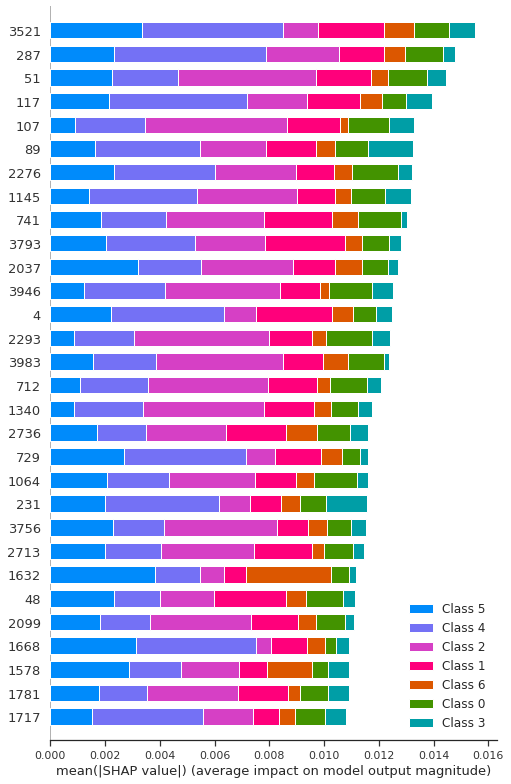

 * Initialising ...
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 32)                128032    
_________________________________________________________________
batch_normalization_8 (Batch (None, 32)                128       
_________________________________________________________________
activation_8 (Activation)    (None, 32)                0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_9 (Batch (None, 16)                64        
_________________________________________________________________
activation_9 (Activation)    (None

20/20 [==============================] - 0s 4ms/step - loss: 0.6781 - accuracy: 0.9475 - auc: 0.9960 - precision: 0.9990 - recall: 0.4997 - val_loss: 0.7147 - val_accuracy: 0.9459 - val_auc: 0.9963 - val_precision: 0.9921 - val_recall: 0.5239

Epoch 00019: val_loss improved from 0.75835 to 0.71470, saving model to weights/best_model_annotation.h5
Epoch 20/100
20/20 [==============================] - 0s 4ms/step - loss: 0.6416 - accuracy: 0.9563 - auc: 0.9971 - precision: 0.9991 - recall: 0.5590 - val_loss: 0.6861 - val_accuracy: 0.9543 - val_auc: 0.9958 - val_precision: 0.9895 - val_recall: 0.5863

Epoch 00020: val_loss improved from 0.71470 to 0.68612, saving model to weights/best_model_annotation.h5
Epoch 21/100
20/20 [==============================] - 0s 3ms/step - loss: 0.6101 - accuracy: 0.9459 - auc: 0.9971 - precision: 0.9991 - recall: 0.5871 - val_loss: 0.6612 - val_accuracy: 0.9543 - val_auc: 0.9959 - val_precision: 0.9902 - val_recall: 0.6279

Epoch 00021: val_loss improved f


Epoch 00042: val_loss improved from 0.35720 to 0.34454, saving model to weights/best_model_annotation.h5
Epoch 43/100
20/20 [==============================] - 0s 4ms/step - loss: 0.2408 - accuracy: 0.9870 - auc: 0.9998 - precision: 1.0000 - recall: 0.9303 - val_loss: 0.3230 - val_accuracy: 0.9563 - val_auc: 0.9955 - val_precision: 0.9651 - val_recall: 0.9189

Epoch 00043: val_loss improved from 0.34454 to 0.32301, saving model to weights/best_model_annotation.h5
Epoch 44/100
20/20 [==============================] - 0s 4ms/step - loss: 0.2292 - accuracy: 0.9901 - auc: 0.9998 - precision: 0.9978 - recall: 0.9428 - val_loss: 0.3199 - val_accuracy: 0.9522 - val_auc: 0.9956 - val_precision: 0.9630 - val_recall: 0.9189

Epoch 00044: val_loss improved from 0.32301 to 0.31993, saving model to weights/best_model_annotation.h5
Epoch 45/100
20/20 [==============================] - 0s 4ms/step - loss: 0.2207 - accuracy: 0.9922 - auc: 0.9999 - precision: 0.9978 - recall: 0.9558 - val_loss: 0.3341 

20/20 [==============================] - 0s 4ms/step - loss: 0.1169 - accuracy: 0.9943 - auc: 1.0000 - precision: 0.9989 - recall: 0.9839 - val_loss: 0.2190 - val_accuracy: 0.9563 - val_auc: 0.9948 - val_precision: 0.9637 - val_recall: 0.9376

Epoch 00067: val_loss improved from 0.22293 to 0.21902, saving model to weights/best_model_annotation.h5
Epoch 68/100
20/20 [==============================] - 0s 4ms/step - loss: 0.1093 - accuracy: 0.9948 - auc: 1.0000 - precision: 0.9979 - recall: 0.9860 - val_loss: 0.2148 - val_accuracy: 0.9563 - val_auc: 0.9950 - val_precision: 0.9617 - val_recall: 0.9397

Epoch 00068: val_loss improved from 0.21902 to 0.21476, saving model to weights/best_model_annotation.h5
Epoch 69/100
20/20 [==============================] - 0s 4ms/step - loss: 0.1149 - accuracy: 0.9938 - auc: 0.9999 - precision: 0.9953 - recall: 0.9828 - val_loss: 0.2166 - val_accuracy: 0.9563 - val_auc: 0.9944 - val_precision: 0.9637 - val_recall: 0.9376

Epoch 00069: val_loss did not im

20/20 [==============================] - 0s 4ms/step - loss: 0.0687 - accuracy: 0.9948 - auc: 1.0000 - precision: 0.9974 - recall: 0.9901 - val_loss: 0.1891 - val_accuracy: 0.9584 - val_auc: 0.9944 - val_precision: 0.9579 - val_recall: 0.9459

Epoch 00092: val_loss did not improve from 0.18361
Epoch 00092: early stopping


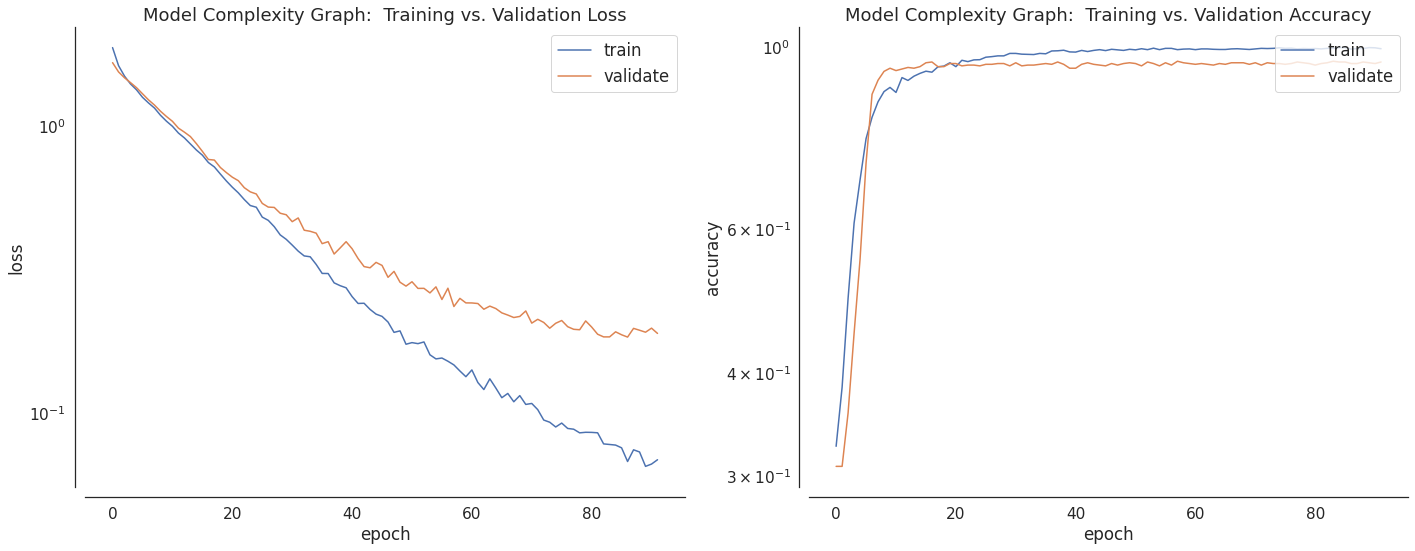

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

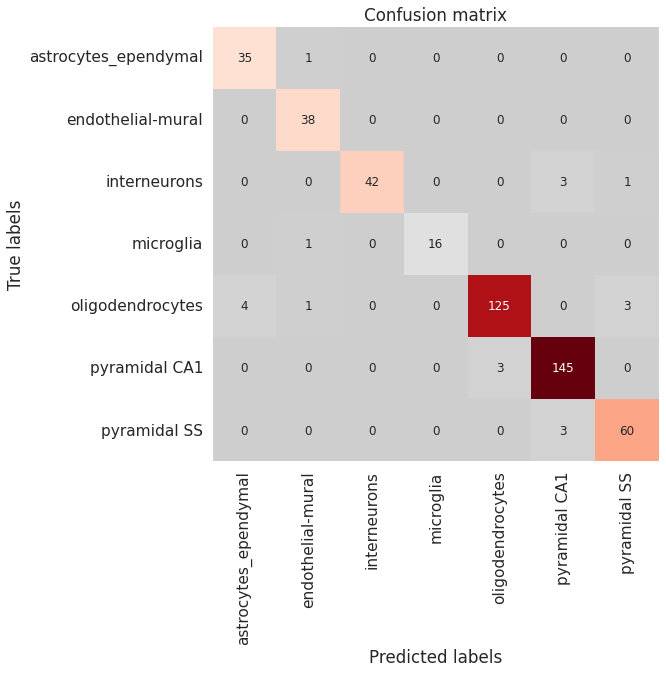

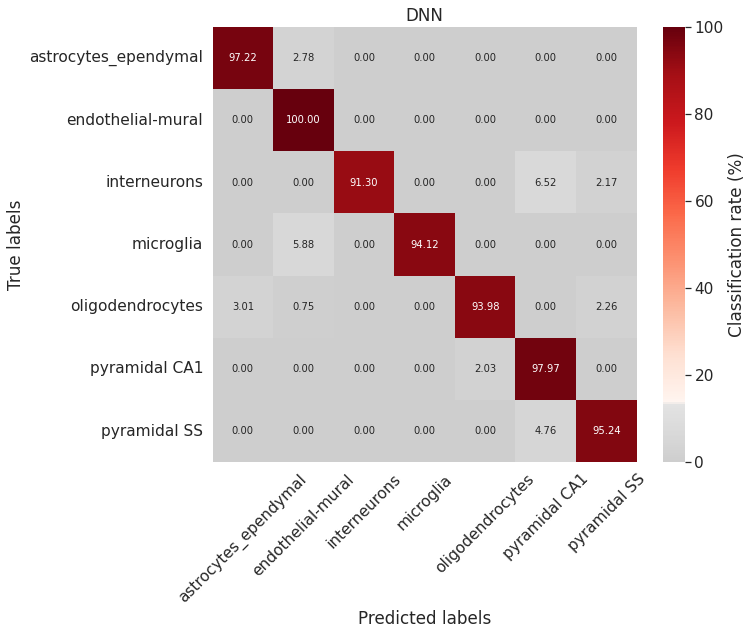

                      precision    recall  f1-score   support

astrocytes_ependymal       0.90      0.97      0.93        36
   endothelial-mural       0.93      1.00      0.96        38
        interneurons       1.00      0.91      0.95        46
           microglia       1.00      0.94      0.97        17
    oligodendrocytes       0.98      0.94      0.96       133
       pyramidal CA1       0.96      0.98      0.97       148
        pyramidal SS       0.94      0.95      0.94        63

            accuracy                           0.96       481
           macro avg       0.96      0.96      0.96       481
        weighted avg       0.96      0.96      0.96       481

16/16 [==============================] - 0s 1ms/step - loss: 0.1836 - accuracy: 0.9543 - auc: 0.9955 - precision: 0.9659 - recall: 0.9418


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


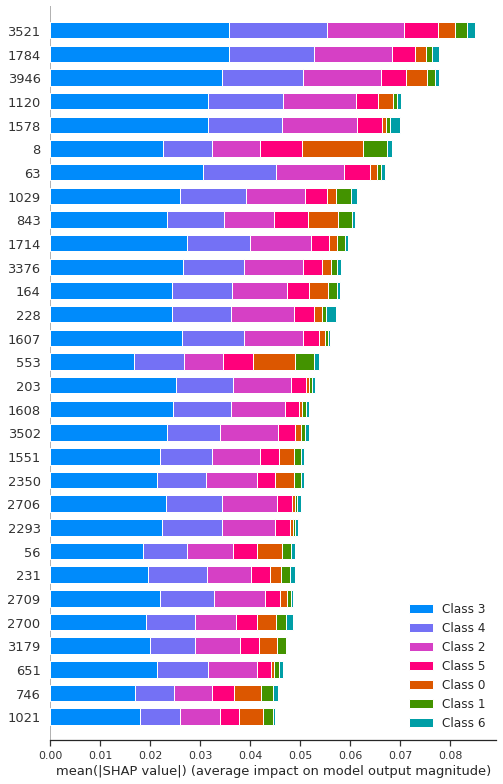

 * Initialising ...
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 32)                128032    
_________________________________________________________________
batch_normalization_12 (Batc (None, 32)                128       
_________________________________________________________________
activation_12 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_13 (Batc (None, 16)                64        
_________________________________________________________________
activation_13 (Activation)   (None

20/20 [==============================] - 0s 4ms/step - loss: 0.6676 - accuracy: 0.9438 - auc: 0.9962 - precision: 1.0000 - recall: 0.5174 - val_loss: 0.7020 - val_accuracy: 0.9626 - val_auc: 0.9948 - val_precision: 0.9926 - val_recall: 0.5572

Epoch 00019: val_loss improved from 0.75071 to 0.70199, saving model to weights/best_model_annotation.h5
Epoch 20/100
20/20 [==============================] - 0s 4ms/step - loss: 0.6516 - accuracy: 0.9459 - auc: 0.9972 - precision: 1.0000 - recall: 0.5231 - val_loss: 0.6701 - val_accuracy: 0.9626 - val_auc: 0.9951 - val_precision: 0.9934 - val_recall: 0.6279

Epoch 00020: val_loss improved from 0.70199 to 0.67012, saving model to weights/best_model_annotation.h5
Epoch 21/100
20/20 [==============================] - 0s 4ms/step - loss: 0.6148 - accuracy: 0.9511 - auc: 0.9974 - precision: 0.9982 - recall: 0.5772 - val_loss: 0.6545 - val_accuracy: 0.9584 - val_auc: 0.9951 - val_precision: 0.9938 - val_recall: 0.6674

Epoch 00021: val_loss improved f

20/20 [==============================] - 0s 4ms/step - loss: 0.2488 - accuracy: 0.9886 - auc: 0.9999 - precision: 0.9989 - recall: 0.9329 - val_loss: 0.3121 - val_accuracy: 0.9605 - val_auc: 0.9950 - val_precision: 0.9801 - val_recall: 0.9231

Epoch 00042: val_loss improved from 0.34211 to 0.31214, saving model to weights/best_model_annotation.h5
Epoch 43/100
20/20 [==============================] - 0s 4ms/step - loss: 0.2511 - accuracy: 0.9823 - auc: 0.9997 - precision: 0.9961 - recall: 0.9277 - val_loss: 0.3072 - val_accuracy: 0.9647 - val_auc: 0.9952 - val_precision: 0.9759 - val_recall: 0.9252

Epoch 00043: val_loss improved from 0.31214 to 0.30724, saving model to weights/best_model_annotation.h5
Epoch 44/100
20/20 [==============================] - 0s 4ms/step - loss: 0.2302 - accuracy: 0.9875 - auc: 0.9998 - precision: 0.9984 - recall: 0.9470 - val_loss: 0.2930 - val_accuracy: 0.9605 - val_auc: 0.9950 - val_precision: 0.9759 - val_recall: 0.9252

Epoch 00044: val_loss improved f


Epoch 00065: val_loss improved from 0.21582 to 0.21485, saving model to weights/best_model_annotation.h5
Epoch 66/100
20/20 [==============================] - 0s 4ms/step - loss: 0.1178 - accuracy: 0.9938 - auc: 1.0000 - precision: 0.9974 - recall: 0.9823 - val_loss: 0.2117 - val_accuracy: 0.9543 - val_auc: 0.9949 - val_precision: 0.9599 - val_recall: 0.9459

Epoch 00066: val_loss improved from 0.21485 to 0.21170, saving model to weights/best_model_annotation.h5
Epoch 67/100
20/20 [==============================] - 0s 4ms/step - loss: 0.1185 - accuracy: 0.9943 - auc: 0.9999 - precision: 0.9974 - recall: 0.9813 - val_loss: 0.2069 - val_accuracy: 0.9563 - val_auc: 0.9945 - val_precision: 0.9662 - val_recall: 0.9501

Epoch 00067: val_loss improved from 0.21170 to 0.20686, saving model to weights/best_model_annotation.h5
Epoch 68/100
20/20 [==============================] - 0s 4ms/step - loss: 0.1055 - accuracy: 0.9964 - auc: 1.0000 - precision: 0.9984 - recall: 0.9880 - val_loss: 0.2003 

20/20 [==============================] - 0s 4ms/step - loss: 0.0687 - accuracy: 0.9953 - auc: 1.0000 - precision: 0.9979 - recall: 0.9891 - val_loss: 0.1752 - val_accuracy: 0.9584 - val_auc: 0.9944 - val_precision: 0.9663 - val_recall: 0.9543

Epoch 00090: val_loss did not improve from 0.16928
Epoch 00090: early stopping


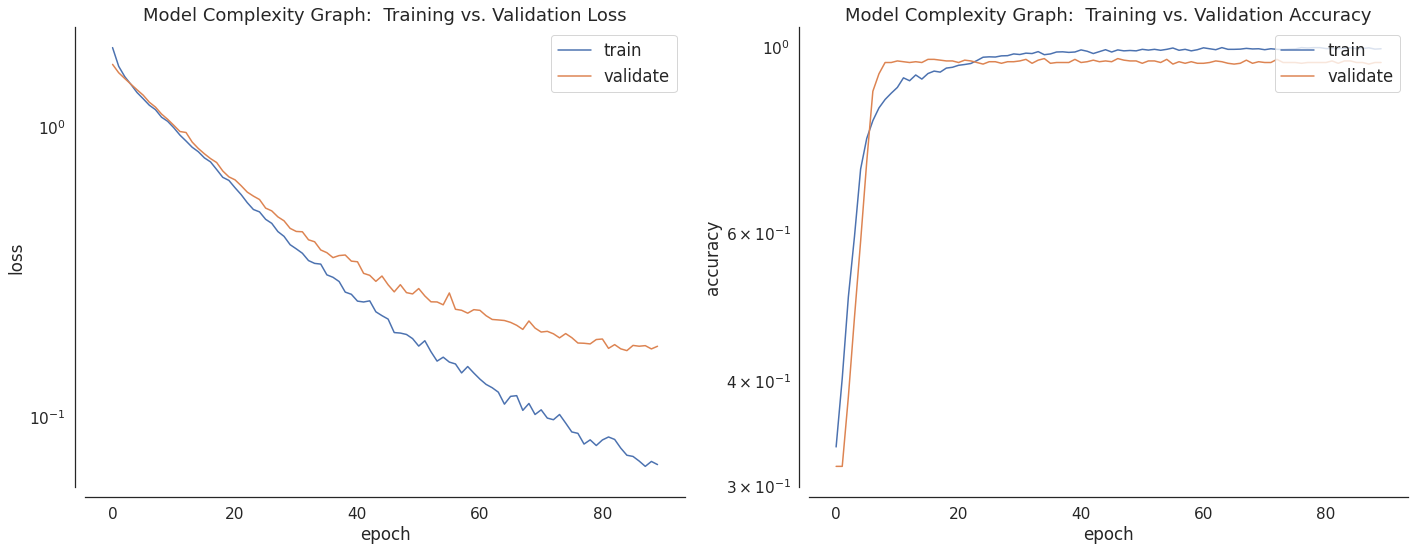

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

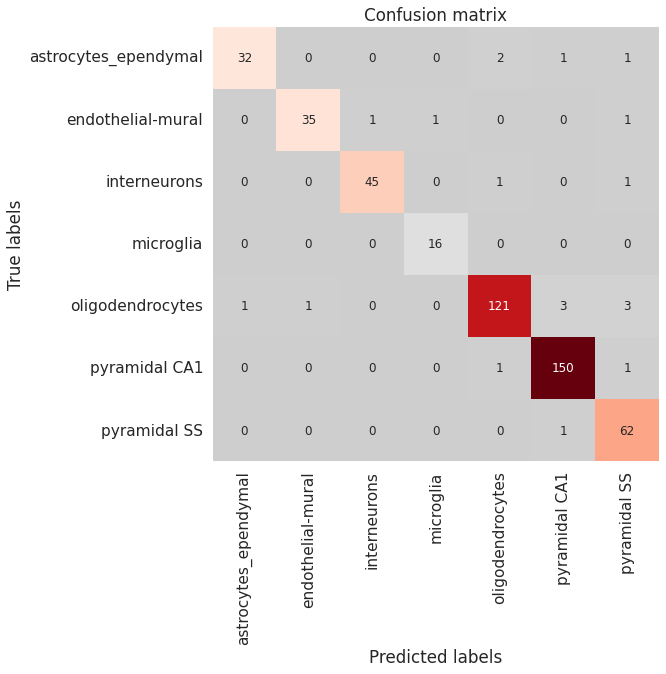

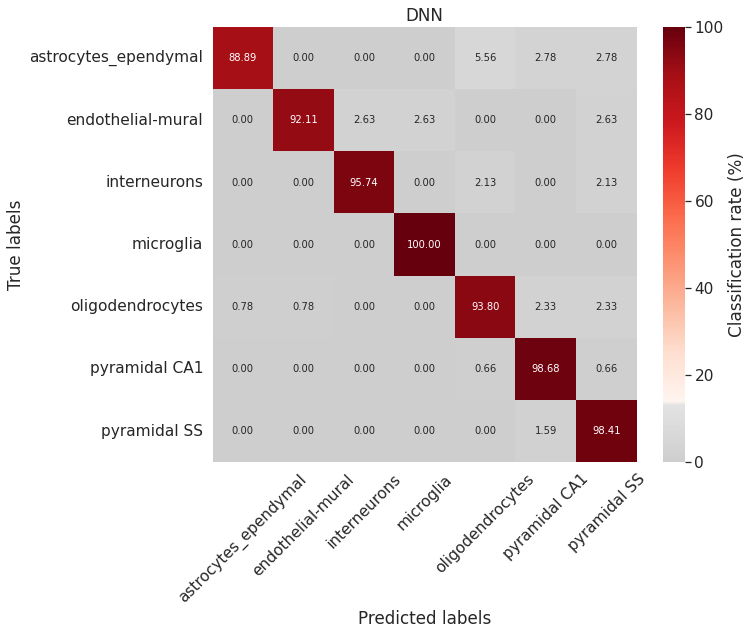

                      precision    recall  f1-score   support

astrocytes_ependymal       0.97      0.89      0.93        36
   endothelial-mural       0.97      0.92      0.95        38
        interneurons       0.98      0.96      0.97        47
           microglia       0.94      1.00      0.97        16
    oligodendrocytes       0.97      0.94      0.95       129
       pyramidal CA1       0.97      0.99      0.98       152
        pyramidal SS       0.90      0.98      0.94        63

            accuracy                           0.96       481
           macro avg       0.96      0.95      0.95       481
        weighted avg       0.96      0.96      0.96       481

16/16 [==============================] - 0s 1ms/step - loss: 0.1693 - accuracy: 0.9626 - auc: 0.9946 - precision: 0.9705 - recall: 0.9563


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


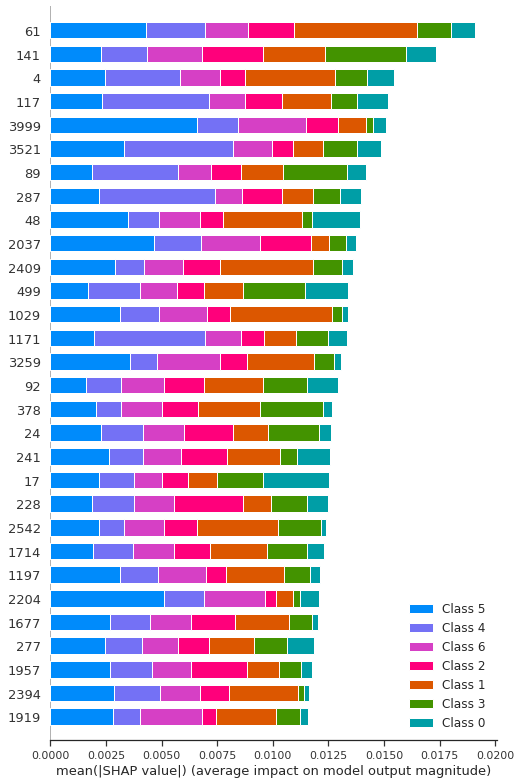

 * Initialising ...
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 32)                128032    
_________________________________________________________________
batch_normalization_16 (Batc (None, 32)                128       
_________________________________________________________________
activation_16 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_17 (Batc (None, 16)                64        
_________________________________________________________________
activation_17 (Activation)   (None

20/20 [==============================] - 0s 3ms/step - loss: 0.6763 - accuracy: 0.9485 - auc: 0.9965 - precision: 0.9968 - recall: 0.4925 - val_loss: 0.7278 - val_accuracy: 0.9584 - val_auc: 0.9953 - val_precision: 0.9960 - val_recall: 0.5135

Epoch 00019: val_loss improved from 0.77943 to 0.72775, saving model to weights/best_model_annotation.h5
Epoch 20/100
20/20 [==============================] - 0s 4ms/step - loss: 0.6441 - accuracy: 0.9496 - auc: 0.9970 - precision: 0.9980 - recall: 0.5273 - val_loss: 0.6976 - val_accuracy: 0.9605 - val_auc: 0.9954 - val_precision: 0.9963 - val_recall: 0.5572

Epoch 00020: val_loss improved from 0.72775 to 0.69755, saving model to weights/best_model_annotation.h5
Epoch 21/100
20/20 [==============================] - 0s 4ms/step - loss: 0.6129 - accuracy: 0.9532 - auc: 0.9976 - precision: 1.0000 - recall: 0.5809 - val_loss: 0.6821 - val_accuracy: 0.9543 - val_auc: 0.9950 - val_precision: 0.9931 - val_recall: 0.5988

Epoch 00021: val_loss improved f

20/20 [==============================] - 0s 4ms/step - loss: 0.2413 - accuracy: 0.9880 - auc: 0.9998 - precision: 0.9978 - recall: 0.9397 - val_loss: 0.3307 - val_accuracy: 0.9647 - val_auc: 0.9957 - val_precision: 0.9823 - val_recall: 0.9210

Epoch 00042: val_loss improved from 0.33759 to 0.33073, saving model to weights/best_model_annotation.h5
Epoch 43/100
20/20 [==============================] - 0s 4ms/step - loss: 0.2410 - accuracy: 0.9880 - auc: 0.9998 - precision: 0.9983 - recall: 0.9355 - val_loss: 0.3177 - val_accuracy: 0.9626 - val_auc: 0.9956 - val_precision: 0.9823 - val_recall: 0.9252

Epoch 00043: val_loss improved from 0.33073 to 0.31773, saving model to weights/best_model_annotation.h5
Epoch 44/100
20/20 [==============================] - 0s 4ms/step - loss: 0.2272 - accuracy: 0.9875 - auc: 0.9999 - precision: 0.9984 - recall: 0.9449 - val_loss: 0.3105 - val_accuracy: 0.9563 - val_auc: 0.9958 - val_precision: 0.9823 - val_recall: 0.9231

Epoch 00044: val_loss improved f

20/20 [==============================] - 0s 4ms/step - loss: 0.1218 - accuracy: 0.9927 - auc: 0.9999 - precision: 0.9958 - recall: 0.9818 - val_loss: 0.2085 - val_accuracy: 0.9647 - val_auc: 0.9963 - val_precision: 0.9723 - val_recall: 0.9480

Epoch 00066: val_loss improved from 0.20874 to 0.20849, saving model to weights/best_model_annotation.h5
Epoch 67/100
20/20 [==============================] - 0s 4ms/step - loss: 0.1124 - accuracy: 0.9953 - auc: 1.0000 - precision: 0.9989 - recall: 0.9823 - val_loss: 0.1980 - val_accuracy: 0.9605 - val_auc: 0.9965 - val_precision: 0.9724 - val_recall: 0.9522

Epoch 00067: val_loss improved from 0.20849 to 0.19805, saving model to weights/best_model_annotation.h5
Epoch 68/100
20/20 [==============================] - 0s 4ms/step - loss: 0.1076 - accuracy: 0.9958 - auc: 1.0000 - precision: 0.9989 - recall: 0.9891 - val_loss: 0.1994 - val_accuracy: 0.9626 - val_auc: 0.9965 - val_precision: 0.9725 - val_recall: 0.9563

Epoch 00068: val_loss did not im

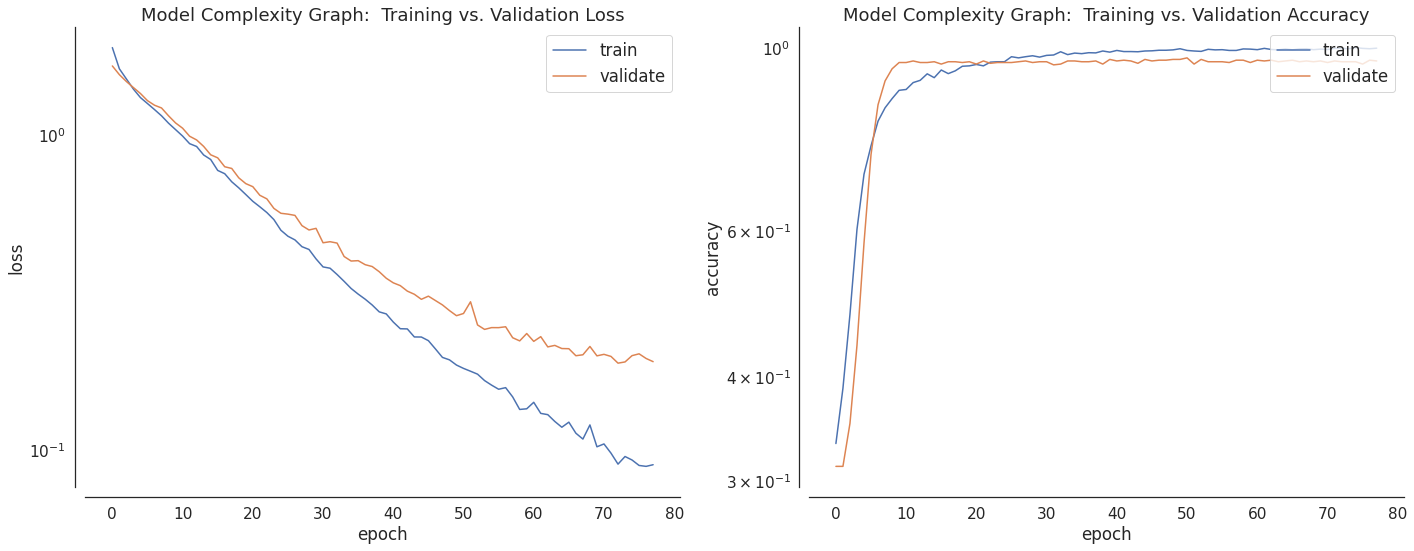

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

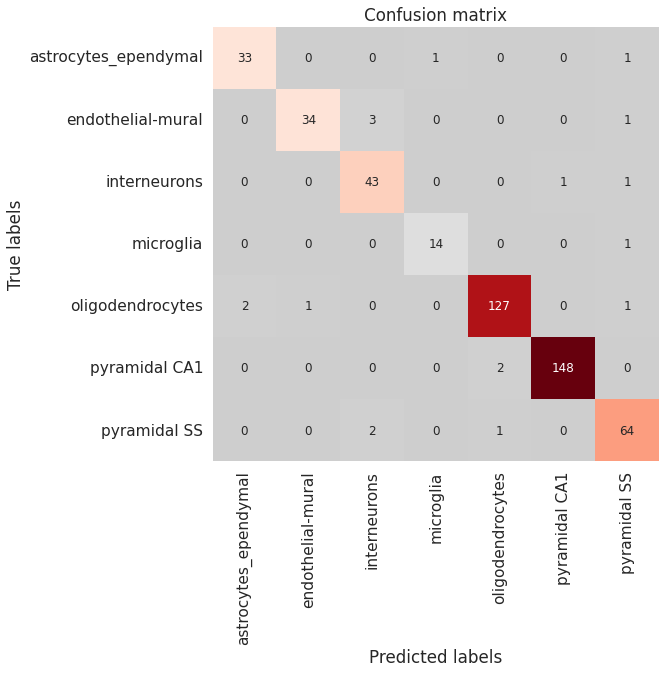

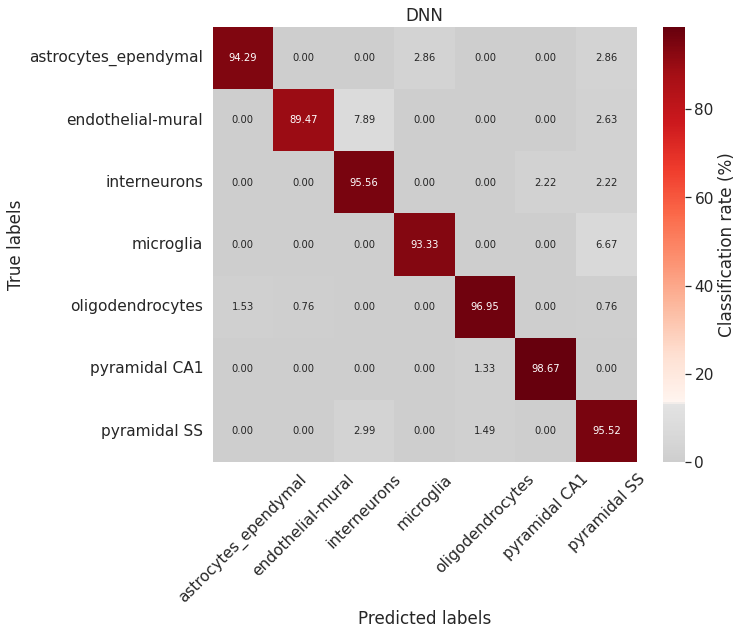

                      precision    recall  f1-score   support

astrocytes_ependymal       0.94      0.94      0.94        35
   endothelial-mural       0.97      0.89      0.93        38
        interneurons       0.90      0.96      0.92        45
           microglia       0.93      0.93      0.93        15
    oligodendrocytes       0.98      0.97      0.97       131
       pyramidal CA1       0.99      0.99      0.99       150
        pyramidal SS       0.93      0.96      0.94        67

            accuracy                           0.96       481
           macro avg       0.95      0.95      0.95       481
        weighted avg       0.96      0.96      0.96       481

16/16 [==============================] - 0s 1ms/step - loss: 0.1876 - accuracy: 0.9605 - auc: 0.9966 - precision: 0.9723 - recall: 0.9501


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


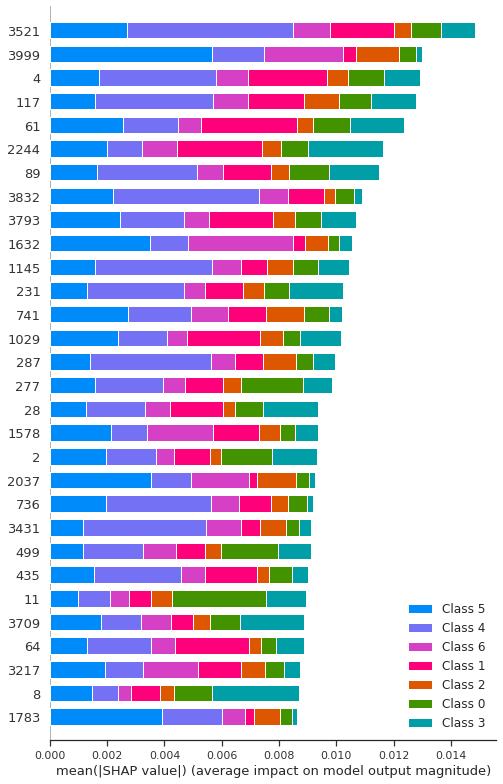

 * Initialising ...
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 32)                128032    
_________________________________________________________________
batch_normalization_20 (Batc (None, 32)                128       
_________________________________________________________________
activation_20 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_21 (Batc (None, 16)                64        
_________________________________________________________________
activation_21 (Activation)   (Non

20/20 [==============================] - 0s 3ms/step - loss: 0.6694 - accuracy: 0.9475 - auc: 0.9960 - precision: 0.9990 - recall: 0.5049 - val_loss: 0.7253 - val_accuracy: 0.9439 - val_auc: 0.9973 - val_precision: 0.9961 - val_recall: 0.5322

Epoch 00019: val_loss improved from 0.76496 to 0.72532, saving model to weights/best_model_annotation.h5
Epoch 20/100
20/20 [==============================] - 0s 4ms/step - loss: 0.6513 - accuracy: 0.9506 - auc: 0.9974 - precision: 1.0000 - recall: 0.5294 - val_loss: 0.6988 - val_accuracy: 0.9501 - val_auc: 0.9969 - val_precision: 0.9929 - val_recall: 0.5842

Epoch 00020: val_loss improved from 0.72532 to 0.69875, saving model to weights/best_model_annotation.h5
Epoch 21/100
20/20 [==============================] - 0s 4ms/step - loss: 0.6249 - accuracy: 0.9542 - auc: 0.9972 - precision: 1.0000 - recall: 0.5829 - val_loss: 0.6688 - val_accuracy: 0.9480 - val_auc: 0.9973 - val_precision: 0.9903 - val_recall: 0.6362

Epoch 00021: val_loss improved f

20/20 [==============================] - 0s 4ms/step - loss: 0.2428 - accuracy: 0.9906 - auc: 0.9999 - precision: 0.9989 - recall: 0.9402 - val_loss: 0.3270 - val_accuracy: 0.9563 - val_auc: 0.9974 - val_precision: 0.9774 - val_recall: 0.8981

Epoch 00042: val_loss improved from 0.34516 to 0.32702, saving model to weights/best_model_annotation.h5
Epoch 43/100
20/20 [==============================] - 0s 4ms/step - loss: 0.2413 - accuracy: 0.9917 - auc: 0.9999 - precision: 0.9994 - recall: 0.9402 - val_loss: 0.3220 - val_accuracy: 0.9522 - val_auc: 0.9971 - val_precision: 0.9775 - val_recall: 0.9023

Epoch 00043: val_loss improved from 0.32702 to 0.32196, saving model to weights/best_model_annotation.h5
Epoch 44/100
20/20 [==============================] - 0s 4ms/step - loss: 0.2312 - accuracy: 0.9917 - auc: 0.9999 - precision: 0.9989 - recall: 0.9412 - val_loss: 0.3104 - val_accuracy: 0.9584 - val_auc: 0.9970 - val_precision: 0.9732 - val_recall: 0.9044

Epoch 00044: val_loss improved f


Epoch 00065: val_loss improved from 0.21695 to 0.21164, saving model to weights/best_model_annotation.h5
Epoch 66/100
20/20 [==============================] - 0s 4ms/step - loss: 0.1150 - accuracy: 0.9964 - auc: 1.0000 - precision: 1.0000 - recall: 0.9828 - val_loss: 0.2210 - val_accuracy: 0.9522 - val_auc: 0.9973 - val_precision: 0.9634 - val_recall: 0.9314

Epoch 00066: val_loss did not improve from 0.21164
Epoch 67/100
20/20 [==============================] - 0s 3ms/step - loss: 0.1182 - accuracy: 0.9953 - auc: 1.0000 - precision: 0.9995 - recall: 0.9823 - val_loss: 0.2077 - val_accuracy: 0.9563 - val_auc: 0.9976 - val_precision: 0.9657 - val_recall: 0.9356

Epoch 00067: val_loss improved from 0.21164 to 0.20769, saving model to weights/best_model_annotation.h5
Epoch 68/100
20/20 [==============================] - 0s 3ms/step - loss: 0.1118 - accuracy: 0.9943 - auc: 1.0000 - precision: 0.9989 - recall: 0.9854 - val_loss: 0.1986 - val_accuracy: 0.9584 - val_auc: 0.9978 - val_precisi

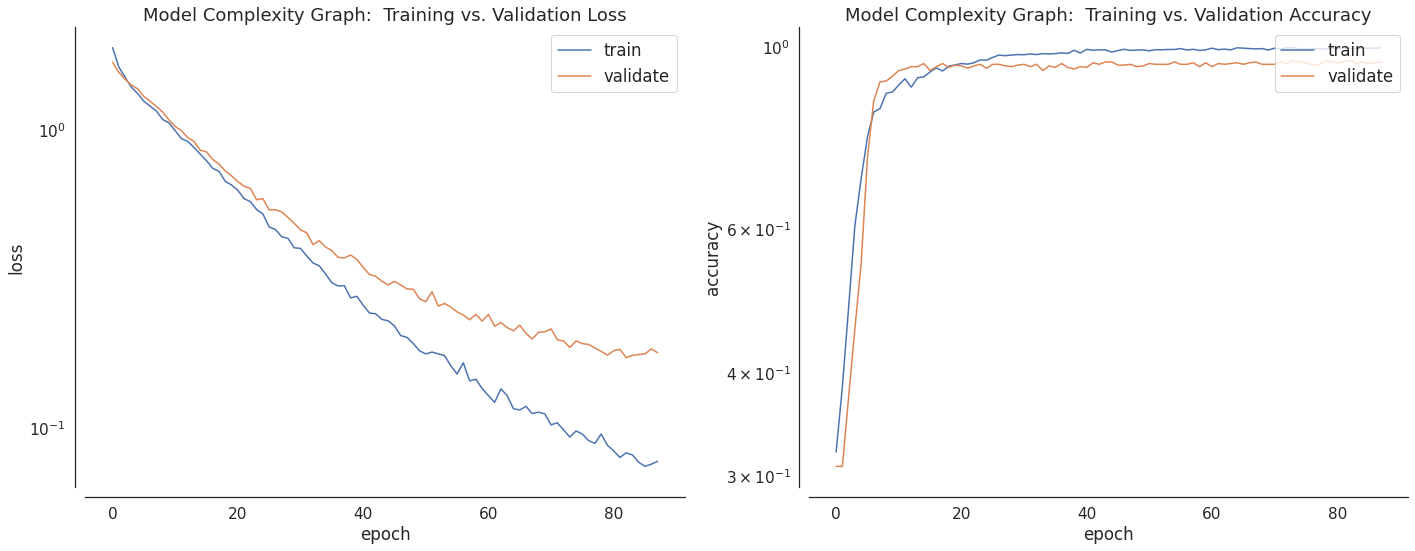

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

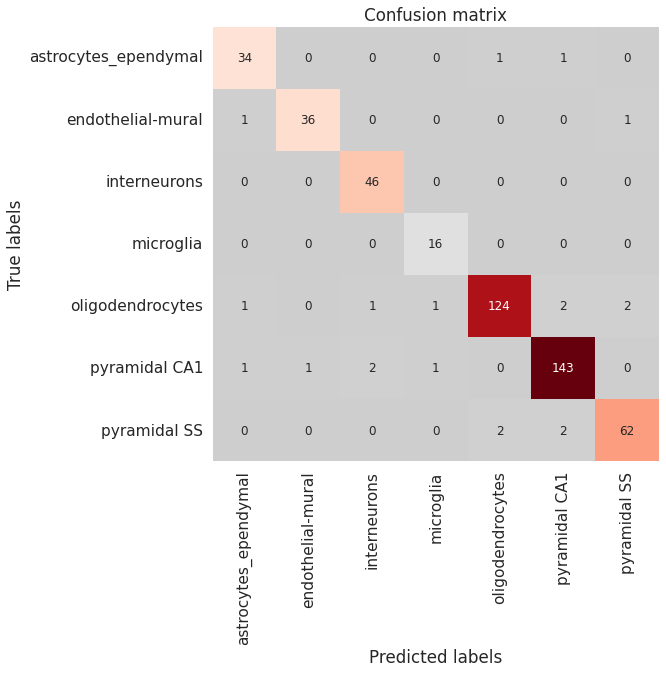

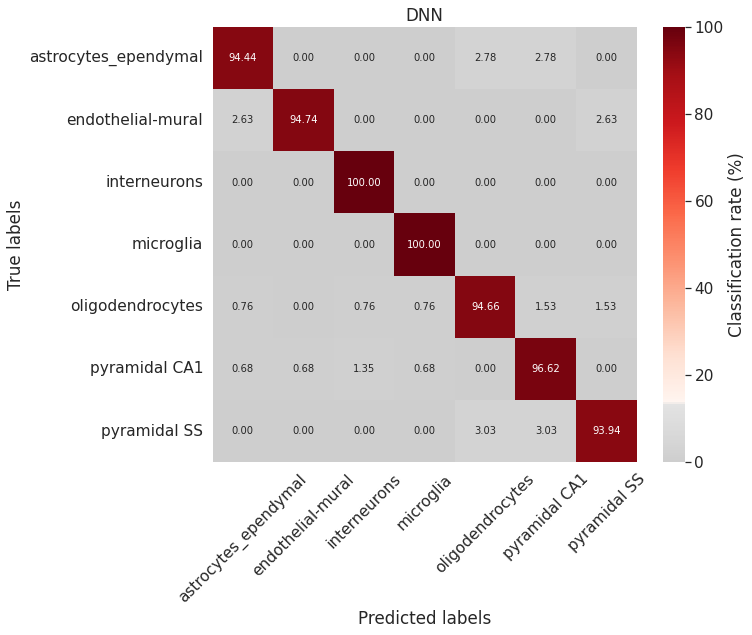

                      precision    recall  f1-score   support

astrocytes_ependymal       0.92      0.94      0.93        36
   endothelial-mural       0.97      0.95      0.96        38
        interneurons       0.94      1.00      0.97        46
           microglia       0.89      1.00      0.94        16
    oligodendrocytes       0.98      0.95      0.96       131
       pyramidal CA1       0.97      0.97      0.97       148
        pyramidal SS       0.95      0.94      0.95        66

            accuracy                           0.96       481
           macro avg       0.95      0.96      0.95       481
        weighted avg       0.96      0.96      0.96       481

16/16 [==============================] - 0s 1ms/step - loss: 0.1721 - accuracy: 0.9626 - auc: 0.9979 - precision: 0.9660 - recall: 0.9439


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


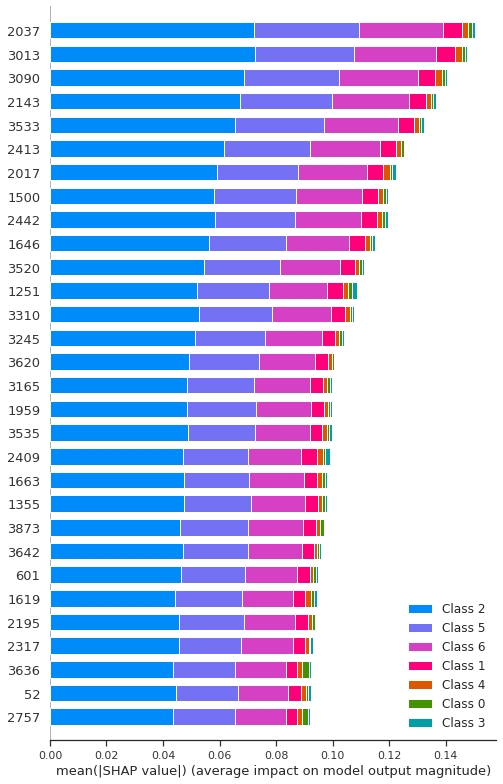

 * Initialising ...
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 32)                128032    
_________________________________________________________________
batch_normalization_24 (Batc (None, 32)                128       
_________________________________________________________________
activation_24 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_25 (Batc (None, 16)                64        
_________________________________________________________________
activation_25 (Activation)   (Non

20/20 [==============================] - 0s 4ms/step - loss: 0.6729 - accuracy: 0.9449 - auc: 0.9966 - precision: 0.9990 - recall: 0.5060 - val_loss: 0.7256 - val_accuracy: 0.9667 - val_auc: 0.9976 - val_precision: 1.0000 - val_recall: 0.5426

Epoch 00019: val_loss improved from 0.77031 to 0.72559, saving model to weights/best_model_annotation.h5
Epoch 20/100
20/20 [==============================] - 0s 4ms/step - loss: 0.6392 - accuracy: 0.9522 - auc: 0.9974 - precision: 0.9991 - recall: 0.5486 - val_loss: 0.7042 - val_accuracy: 0.9563 - val_auc: 0.9974 - val_precision: 1.0000 - val_recall: 0.5738

Epoch 00020: val_loss improved from 0.72559 to 0.70419, saving model to weights/best_model_annotation.h5
Epoch 21/100
20/20 [==============================] - 0s 4ms/step - loss: 0.6102 - accuracy: 0.9480 - auc: 0.9971 - precision: 0.9991 - recall: 0.5980 - val_loss: 0.6749 - val_accuracy: 0.9626 - val_auc: 0.9973 - val_precision: 0.9967 - val_recall: 0.6258

Epoch 00021: val_loss improved f

20/20 [==============================] - 0s 4ms/step - loss: 0.2409 - accuracy: 0.9870 - auc: 0.9998 - precision: 0.9989 - recall: 0.9319 - val_loss: 0.3145 - val_accuracy: 0.9563 - val_auc: 0.9980 - val_precision: 0.9776 - val_recall: 0.9085

Epoch 00043: val_loss improved from 0.33499 to 0.31448, saving model to weights/best_model_annotation.h5
Epoch 44/100
20/20 [==============================] - 0s 4ms/step - loss: 0.2307 - accuracy: 0.9875 - auc: 0.9998 - precision: 0.9983 - recall: 0.9412 - val_loss: 0.3063 - val_accuracy: 0.9543 - val_auc: 0.9980 - val_precision: 0.9800 - val_recall: 0.9148

Epoch 00044: val_loss improved from 0.31448 to 0.30632, saving model to weights/best_model_annotation.h5
Epoch 45/100
20/20 [==============================] - 0s 4ms/step - loss: 0.2252 - accuracy: 0.9912 - auc: 0.9998 - precision: 0.9989 - recall: 0.9501 - val_loss: 0.3167 - val_accuracy: 0.9584 - val_auc: 0.9977 - val_precision: 0.9733 - val_recall: 0.9106

Epoch 00045: val_loss did not im

20/20 [==============================] - 0s 4ms/step - loss: 0.1176 - accuracy: 0.9948 - auc: 1.0000 - precision: 0.9979 - recall: 0.9844 - val_loss: 0.2053 - val_accuracy: 0.9584 - val_auc: 0.9981 - val_precision: 0.9656 - val_recall: 0.9335

Epoch 00067: val_loss improved from 0.20774 to 0.20530, saving model to weights/best_model_annotation.h5
Epoch 68/100
20/20 [==============================] - 0s 4ms/step - loss: 0.1105 - accuracy: 0.9948 - auc: 1.0000 - precision: 0.9968 - recall: 0.9834 - val_loss: 0.1952 - val_accuracy: 0.9584 - val_auc: 0.9983 - val_precision: 0.9636 - val_recall: 0.9356

Epoch 00068: val_loss improved from 0.20530 to 0.19521, saving model to weights/best_model_annotation.h5
Epoch 69/100
20/20 [==============================] - 0s 4ms/step - loss: 0.1203 - accuracy: 0.9927 - auc: 0.9999 - precision: 0.9963 - recall: 0.9787 - val_loss: 0.1914 - val_accuracy: 0.9647 - val_auc: 0.9983 - val_precision: 0.9699 - val_recall: 0.9376

Epoch 00069: val_loss improved f

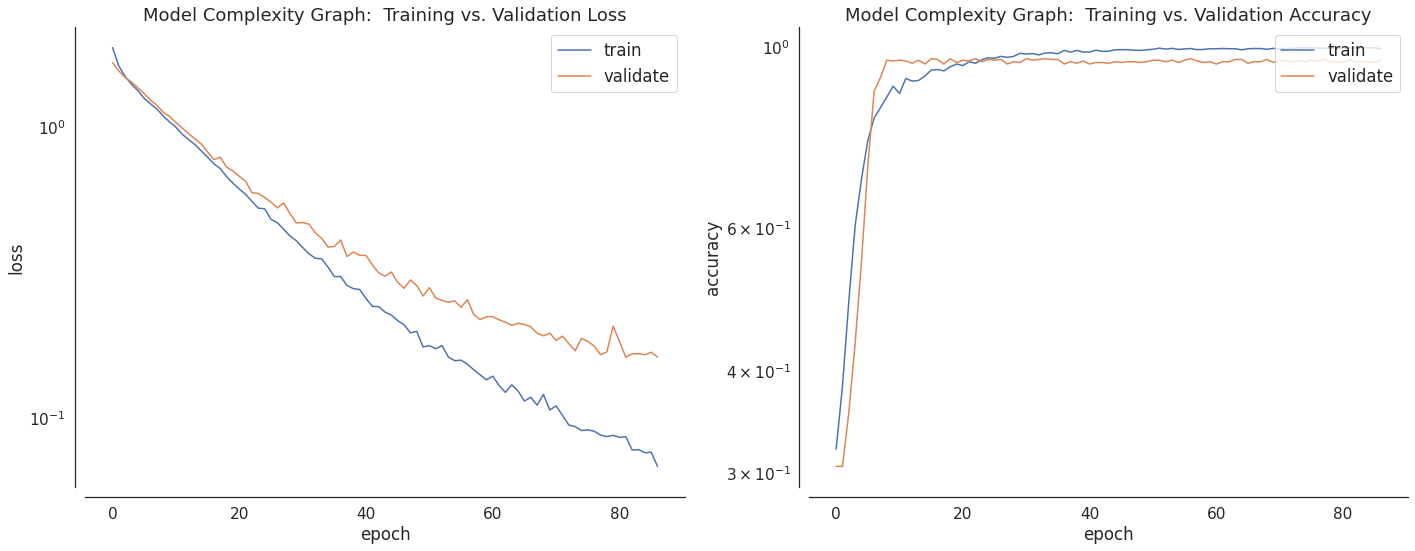

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

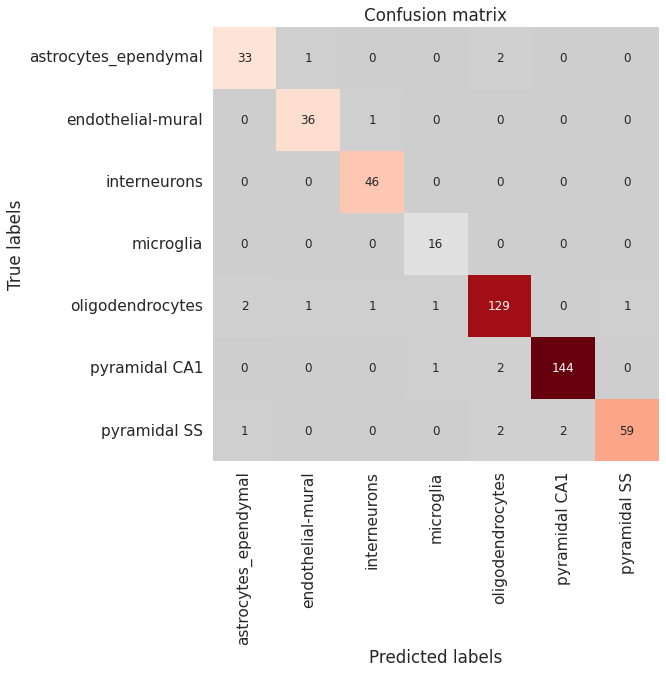

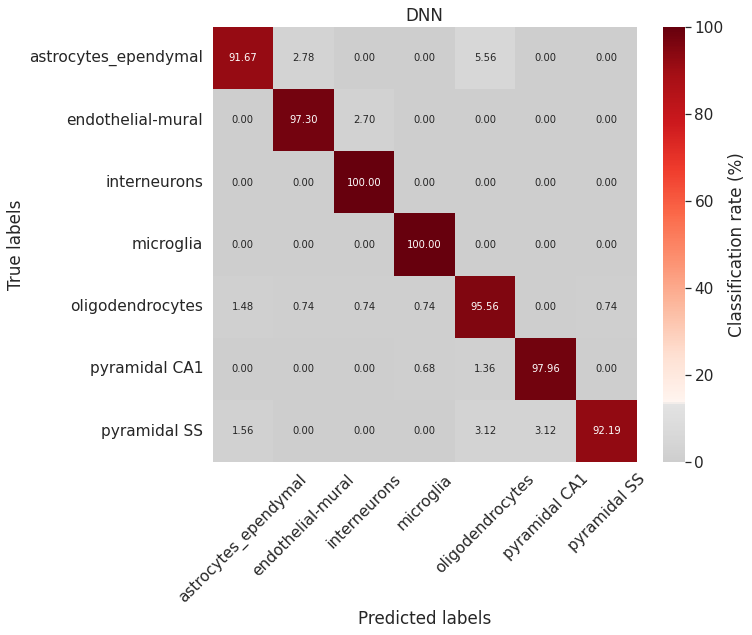

                      precision    recall  f1-score   support

astrocytes_ependymal       0.92      0.92      0.92        36
   endothelial-mural       0.95      0.97      0.96        37
        interneurons       0.96      1.00      0.98        46
           microglia       0.89      1.00      0.94        16
    oligodendrocytes       0.96      0.96      0.96       135
       pyramidal CA1       0.99      0.98      0.98       147
        pyramidal SS       0.98      0.92      0.95        64

            accuracy                           0.96       481
           macro avg       0.95      0.96      0.96       481
        weighted avg       0.96      0.96      0.96       481

16/16 [==============================] - 0s 1ms/step - loss: 0.1614 - accuracy: 0.9647 - auc: 0.9985 - precision: 0.9704 - recall: 0.9543


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


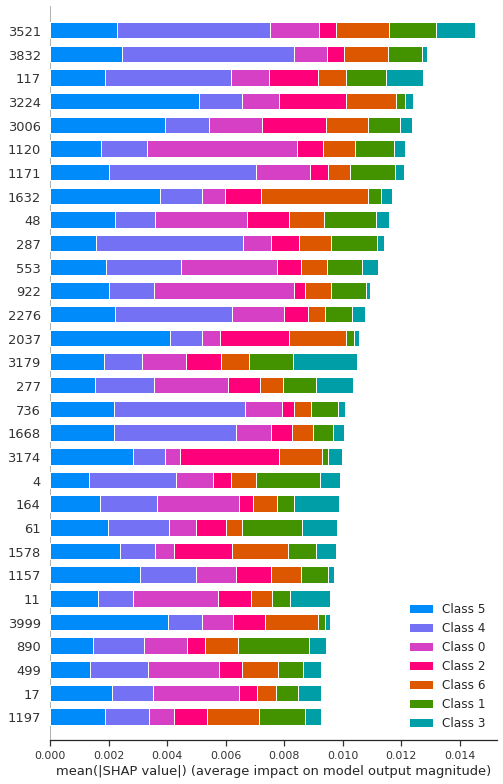

 * Initialising ...
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 32)                128032    
_________________________________________________________________
batch_normalization_28 (Batc (None, 32)                128       
_________________________________________________________________
activation_28 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_43 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_29 (Batc (None, 16)                64        
_________________________________________________________________
activation_29 (Activation)   (Non

20/20 [==============================] - 0s 3ms/step - loss: 0.6702 - accuracy: 0.9542 - auc: 0.9970 - precision: 1.0000 - recall: 0.4966 - val_loss: 0.7449 - val_accuracy: 0.9501 - val_auc: 0.9932 - val_precision: 0.9915 - val_recall: 0.4865

Epoch 00019: val_loss improved from 0.78769 to 0.74486, saving model to weights/best_model_annotation.h5
Epoch 20/100
20/20 [==============================] - 0s 4ms/step - loss: 0.6381 - accuracy: 0.9558 - auc: 0.9974 - precision: 0.9990 - recall: 0.5419 - val_loss: 0.7219 - val_accuracy: 0.9501 - val_auc: 0.9934 - val_precision: 0.9926 - val_recall: 0.5551

Epoch 00020: val_loss improved from 0.74486 to 0.72192, saving model to weights/best_model_annotation.h5
Epoch 21/100
20/20 [==============================] - 0s 4ms/step - loss: 0.6106 - accuracy: 0.9480 - auc: 0.9969 - precision: 1.0000 - recall: 0.5881 - val_loss: 0.6906 - val_accuracy: 0.9480 - val_auc: 0.9937 - val_precision: 0.9933 - val_recall: 0.6133

Epoch 00021: val_loss improved f

20/20 [==============================] - 0s 4ms/step - loss: 0.2420 - accuracy: 0.9880 - auc: 0.9998 - precision: 0.9994 - recall: 0.9433 - val_loss: 0.3778 - val_accuracy: 0.9376 - val_auc: 0.9932 - val_precision: 0.9703 - val_recall: 0.8836

Epoch 00042: val_loss did not improve from 0.37527
Epoch 43/100
20/20 [==============================] - 0s 3ms/step - loss: 0.2406 - accuracy: 0.9849 - auc: 0.9998 - precision: 0.9983 - recall: 0.9324 - val_loss: 0.3403 - val_accuracy: 0.9543 - val_auc: 0.9945 - val_precision: 0.9819 - val_recall: 0.9002

Epoch 00043: val_loss improved from 0.37527 to 0.34031, saving model to weights/best_model_annotation.h5
Epoch 44/100
20/20 [==============================] - 0s 4ms/step - loss: 0.2321 - accuracy: 0.9860 - auc: 0.9998 - precision: 0.9989 - recall: 0.9397 - val_loss: 0.3494 - val_accuracy: 0.9418 - val_auc: 0.9938 - val_precision: 0.9752 - val_recall: 0.9002

Epoch 00044: val_loss did not improve from 0.34031
Epoch 45/100
20/20 [===============


Epoch 00066: val_loss did not improve from 0.23523
Epoch 67/100
20/20 [==============================] - 0s 3ms/step - loss: 0.1192 - accuracy: 0.9932 - auc: 1.0000 - precision: 0.9979 - recall: 0.9823 - val_loss: 0.2513 - val_accuracy: 0.9397 - val_auc: 0.9941 - val_precision: 0.9586 - val_recall: 0.9148

Epoch 00067: val_loss did not improve from 0.23523
Epoch 68/100
20/20 [==============================] - 0s 4ms/step - loss: 0.1124 - accuracy: 0.9932 - auc: 1.0000 - precision: 0.9974 - recall: 0.9792 - val_loss: 0.2302 - val_accuracy: 0.9543 - val_auc: 0.9947 - val_precision: 0.9654 - val_recall: 0.9293

Epoch 00068: val_loss improved from 0.23523 to 0.23022, saving model to weights/best_model_annotation.h5
Epoch 69/100
20/20 [==============================] - 0s 4ms/step - loss: 0.1169 - accuracy: 0.9922 - auc: 0.9999 - precision: 0.9968 - recall: 0.9823 - val_loss: 0.2134 - val_accuracy: 0.9647 - val_auc: 0.9956 - val_precision: 0.9720 - val_recall: 0.9397

Epoch 00069: val_loss


Epoch 00091: val_loss did not improve from 0.17642
Epoch 92/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0691 - accuracy: 0.9953 - auc: 1.0000 - precision: 0.9979 - recall: 0.9896 - val_loss: 0.1924 - val_accuracy: 0.9543 - val_auc: 0.9947 - val_precision: 0.9597 - val_recall: 0.9418

Epoch 00092: val_loss did not improve from 0.17642
Epoch 93/100
20/20 [==============================] - 0s 3ms/step - loss: 0.0594 - accuracy: 0.9979 - auc: 1.0000 - precision: 1.0000 - recall: 0.9953 - val_loss: 0.1887 - val_accuracy: 0.9501 - val_auc: 0.9948 - val_precision: 0.9616 - val_recall: 0.9376

Epoch 00093: val_loss did not improve from 0.17642
Epoch 94/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0667 - accuracy: 0.9964 - auc: 1.0000 - precision: 0.9990 - recall: 0.9912 - val_loss: 0.1868 - val_accuracy: 0.9522 - val_auc: 0.9949 - val_precision: 0.9598 - val_recall: 0.9439

Epoch 00094: val_loss did not improve from 0.17642
Epoch 95/100
20/20 [====

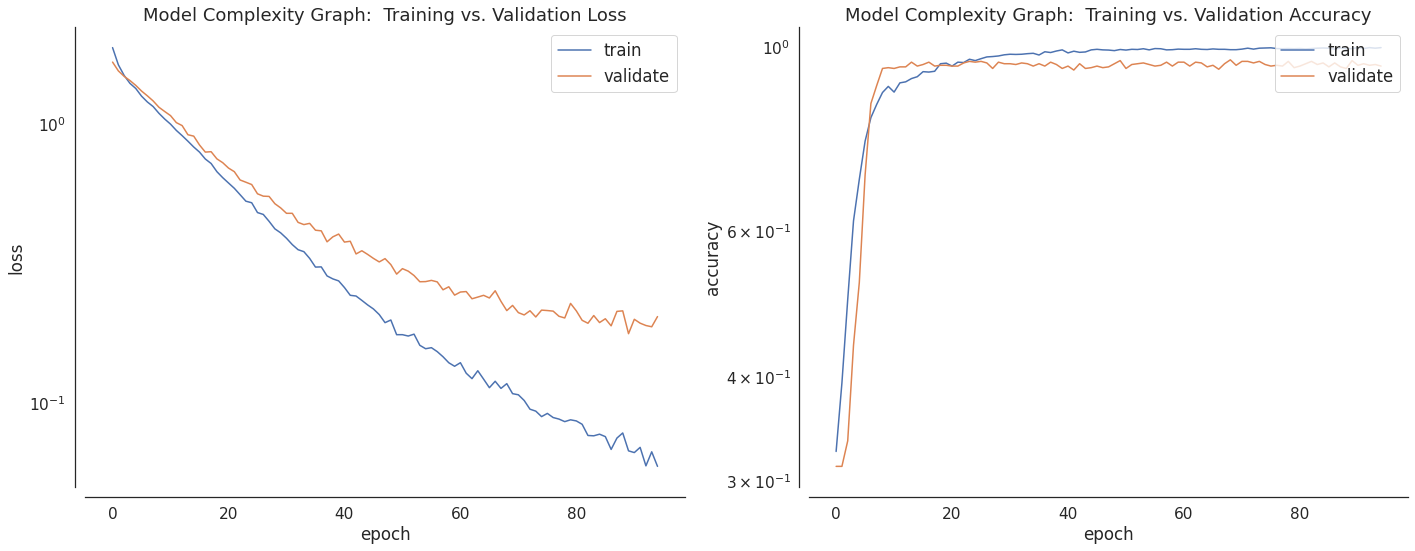

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

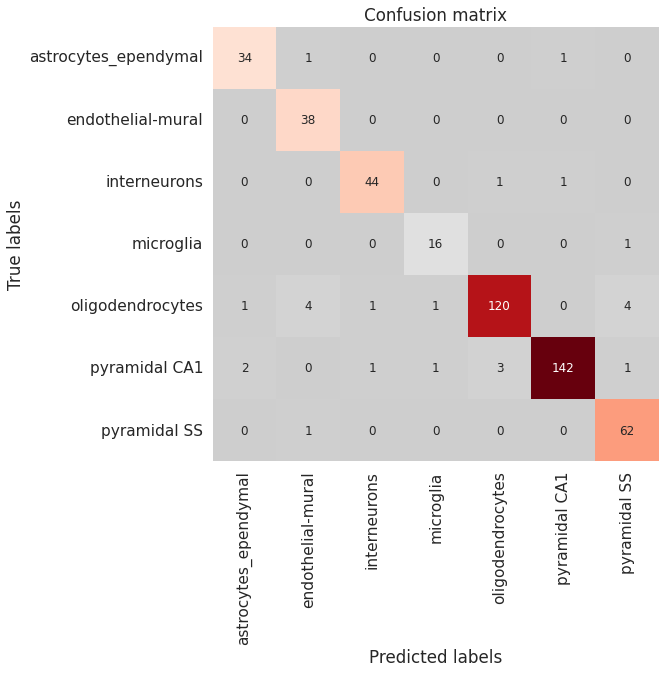

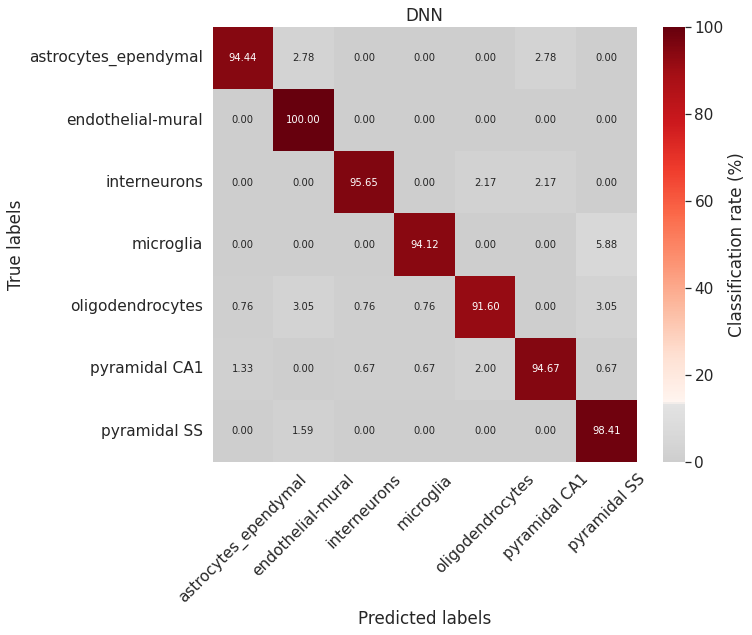

                      precision    recall  f1-score   support

astrocytes_ependymal       0.92      0.94      0.93        36
   endothelial-mural       0.86      1.00      0.93        38
        interneurons       0.96      0.96      0.96        46
           microglia       0.89      0.94      0.91        17
    oligodendrocytes       0.97      0.92      0.94       131
       pyramidal CA1       0.99      0.95      0.97       150
        pyramidal SS       0.91      0.98      0.95        63

            accuracy                           0.95       481
           macro avg       0.93      0.96      0.94       481
        weighted avg       0.95      0.95      0.95       481

16/16 [==============================] - 0s 1ms/step - loss: 0.1764 - accuracy: 0.9626 - auc: 0.9952 - precision: 0.9722 - recall: 0.9439


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


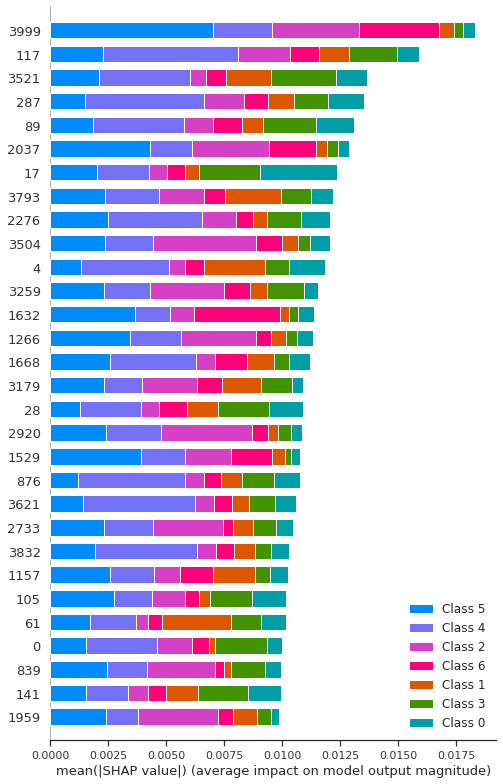

 * Initialising ...
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 32)                128032    
_________________________________________________________________
batch_normalization_32 (Batc (None, 32)                128       
_________________________________________________________________
activation_32 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_49 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_33 (Batc (None, 16)                64        
_________________________________________________________________
activation_33 (Activation)   (Non

20/20 [==============================] - 0s 4ms/step - loss: 0.6752 - accuracy: 0.9464 - auc: 0.9968 - precision: 0.9990 - recall: 0.4977 - val_loss: 0.7565 - val_accuracy: 0.9439 - val_auc: 0.9958 - val_precision: 0.9956 - val_recall: 0.4657

Epoch 00019: val_loss improved from 0.79239 to 0.75649, saving model to weights/best_model_annotation.h5
Epoch 20/100
20/20 [==============================] - 0s 4ms/step - loss: 0.6432 - accuracy: 0.9516 - auc: 0.9973 - precision: 0.9981 - recall: 0.5486 - val_loss: 0.7227 - val_accuracy: 0.9418 - val_auc: 0.9960 - val_precision: 0.9961 - val_recall: 0.5322

Epoch 00020: val_loss improved from 0.75649 to 0.72274, saving model to weights/best_model_annotation.h5
Epoch 21/100
20/20 [==============================] - 0s 4ms/step - loss: 0.6147 - accuracy: 0.9470 - auc: 0.9969 - precision: 0.9991 - recall: 0.5855 - val_loss: 0.6844 - val_accuracy: 0.9480 - val_auc: 0.9963 - val_precision: 0.9966 - val_recall: 0.6091

Epoch 00021: val_loss improved f


Epoch 00042: val_loss did not improve from 0.37576
Epoch 43/100
20/20 [==============================] - 0s 4ms/step - loss: 0.2409 - accuracy: 0.9870 - auc: 0.9998 - precision: 0.9978 - recall: 0.9303 - val_loss: 0.3446 - val_accuracy: 0.9480 - val_auc: 0.9963 - val_precision: 0.9688 - val_recall: 0.9023

Epoch 00043: val_loss improved from 0.37576 to 0.34455, saving model to weights/best_model_annotation.h5
Epoch 44/100
20/20 [==============================] - 0s 4ms/step - loss: 0.2332 - accuracy: 0.9870 - auc: 0.9998 - precision: 0.9983 - recall: 0.9423 - val_loss: 0.3315 - val_accuracy: 0.9522 - val_auc: 0.9964 - val_precision: 0.9689 - val_recall: 0.9064

Epoch 00044: val_loss improved from 0.34455 to 0.33147, saving model to weights/best_model_annotation.h5
Epoch 45/100
20/20 [==============================] - 0s 4ms/step - loss: 0.2282 - accuracy: 0.9901 - auc: 0.9998 - precision: 0.9984 - recall: 0.9449 - val_loss: 0.3509 - val_accuracy: 0.9459 - val_auc: 0.9954 - val_precisi


Epoch 00066: val_loss did not improve from 0.23491
Epoch 67/100
20/20 [==============================] - 0s 3ms/step - loss: 0.1179 - accuracy: 0.9953 - auc: 1.0000 - precision: 0.9989 - recall: 0.9823 - val_loss: 0.2398 - val_accuracy: 0.9418 - val_auc: 0.9960 - val_precision: 0.9568 - val_recall: 0.9210

Epoch 00067: val_loss did not improve from 0.23491
Epoch 68/100
20/20 [==============================] - 0s 4ms/step - loss: 0.1097 - accuracy: 0.9938 - auc: 1.0000 - precision: 0.9984 - recall: 0.9823 - val_loss: 0.2268 - val_accuracy: 0.9439 - val_auc: 0.9963 - val_precision: 0.9550 - val_recall: 0.9272

Epoch 00068: val_loss improved from 0.23491 to 0.22682, saving model to weights/best_model_annotation.h5
Epoch 69/100
20/20 [==============================] - 0s 4ms/step - loss: 0.1173 - accuracy: 0.9927 - auc: 0.9999 - precision: 0.9947 - recall: 0.9823 - val_loss: 0.2207 - val_accuracy: 0.9480 - val_auc: 0.9966 - val_precision: 0.9553 - val_recall: 0.9335

Epoch 00069: val_loss

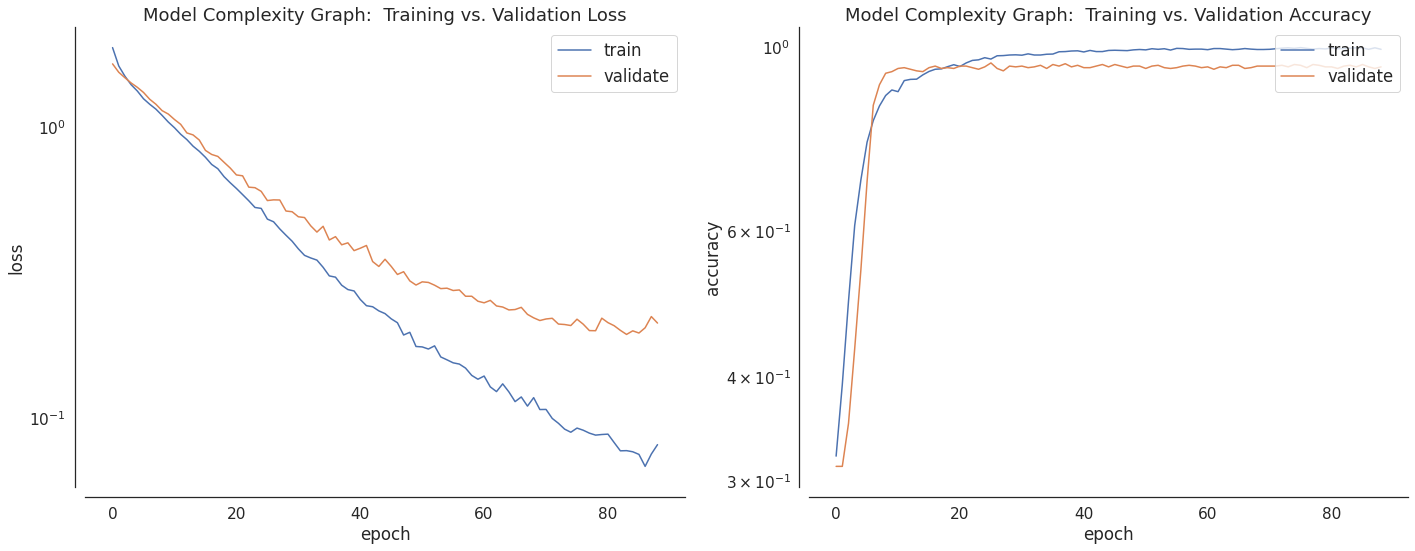

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

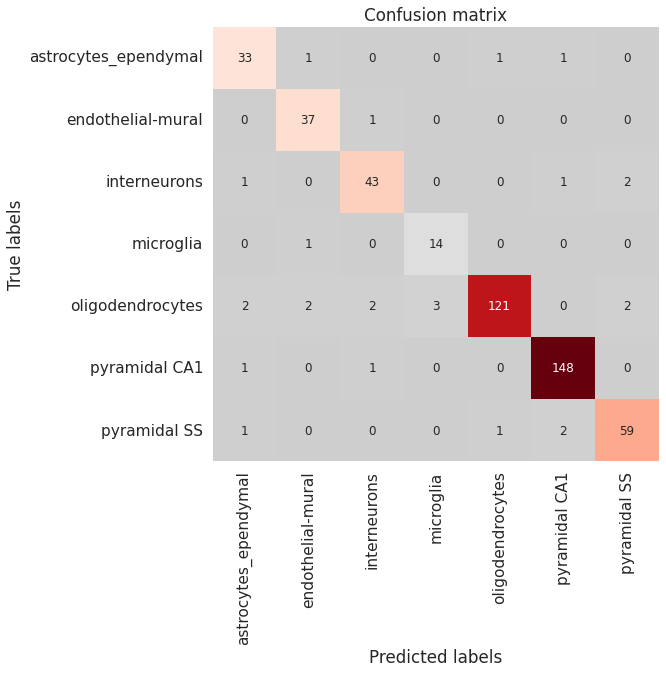

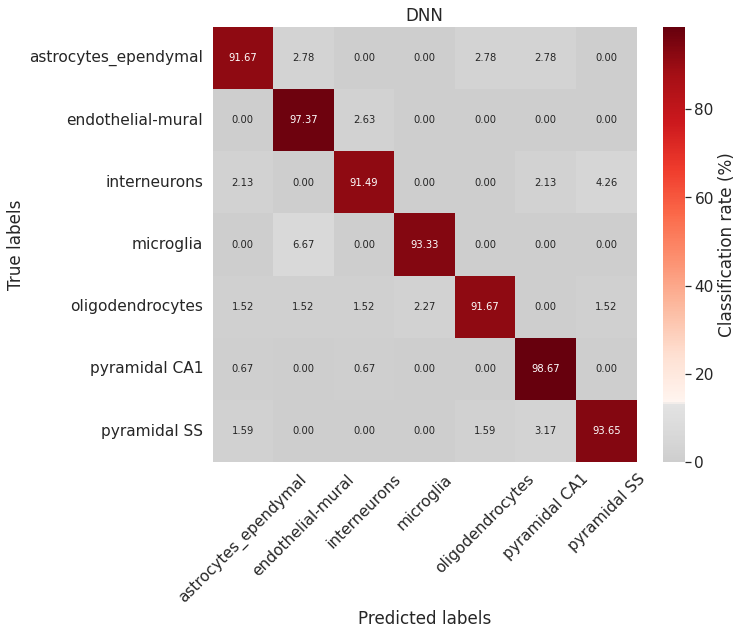

                      precision    recall  f1-score   support

astrocytes_ependymal       0.87      0.92      0.89        36
   endothelial-mural       0.90      0.97      0.94        38
        interneurons       0.91      0.91      0.91        47
           microglia       0.82      0.93      0.87        15
    oligodendrocytes       0.98      0.92      0.95       132
       pyramidal CA1       0.97      0.99      0.98       150
        pyramidal SS       0.94      0.94      0.94        63

            accuracy                           0.95       481
           macro avg       0.91      0.94      0.93       481
        weighted avg       0.95      0.95      0.95       481

16/16 [==============================] - 0s 1ms/step - loss: 0.1935 - accuracy: 0.9501 - auc: 0.9962 - precision: 0.9553 - recall: 0.9335


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


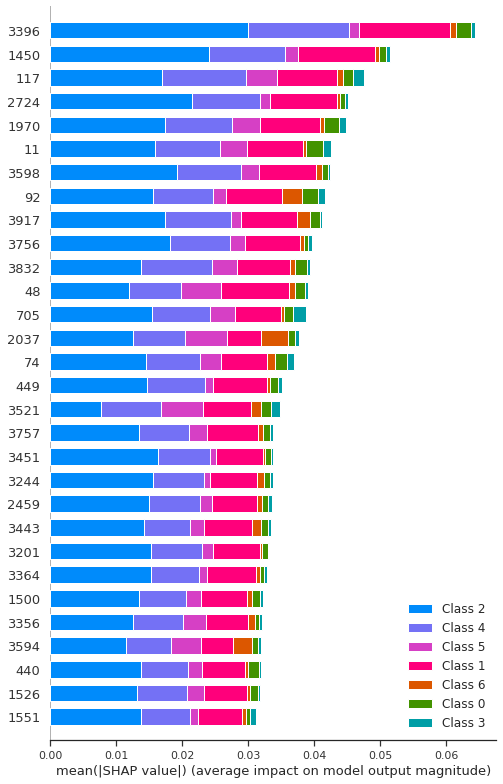

 * Initialising ...
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_54 (Dense)             (None, 32)                128032    
_________________________________________________________________
batch_normalization_36 (Batc (None, 32)                128       
_________________________________________________________________
activation_36 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_55 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_37 (Batc (None, 16)                64        
_________________________________________________________________
activation_37 (Activation)   (Non

20/20 [==============================] - 0s 4ms/step - loss: 0.6825 - accuracy: 0.9501 - auc: 0.9967 - precision: 0.9989 - recall: 0.4935 - val_loss: 0.7378 - val_accuracy: 0.9501 - val_auc: 0.9973 - val_precision: 1.0000 - val_recall: 0.5114

Epoch 00019: val_loss improved from 0.76091 to 0.73778, saving model to weights/best_model_annotation.h5
Epoch 20/100
20/20 [==============================] - 0s 4ms/step - loss: 0.6554 - accuracy: 0.9501 - auc: 0.9964 - precision: 1.0000 - recall: 0.5117 - val_loss: 0.6902 - val_accuracy: 0.9522 - val_auc: 0.9977 - val_precision: 1.0000 - val_recall: 0.6029

Epoch 00020: val_loss improved from 0.73778 to 0.69016, saving model to weights/best_model_annotation.h5
Epoch 21/100
20/20 [==============================] - 0s 4ms/step - loss: 0.6223 - accuracy: 0.9511 - auc: 0.9972 - precision: 1.0000 - recall: 0.5803 - val_loss: 0.6623 - val_accuracy: 0.9563 - val_auc: 0.9978 - val_precision: 1.0000 - val_recall: 0.6549

Epoch 00021: val_loss improved f

20/20 [==============================] - 0s 4ms/step - loss: 0.2584 - accuracy: 0.9886 - auc: 0.9998 - precision: 0.9983 - recall: 0.9360 - val_loss: 0.3274 - val_accuracy: 0.9543 - val_auc: 0.9978 - val_precision: 0.9821 - val_recall: 0.9127

Epoch 00042: val_loss did not improve from 0.32390
Epoch 43/100
20/20 [==============================] - 0s 4ms/step - loss: 0.2427 - accuracy: 0.9912 - auc: 0.9999 - precision: 0.9989 - recall: 0.9438 - val_loss: 0.3165 - val_accuracy: 0.9543 - val_auc: 0.9975 - val_precision: 0.9821 - val_recall: 0.9148

Epoch 00043: val_loss improved from 0.32390 to 0.31652, saving model to weights/best_model_annotation.h5
Epoch 44/100
20/20 [==============================] - 0s 4ms/step - loss: 0.2494 - accuracy: 0.9844 - auc: 0.9997 - precision: 0.9983 - recall: 0.9360 - val_loss: 0.3053 - val_accuracy: 0.9522 - val_auc: 0.9977 - val_precision: 0.9845 - val_recall: 0.9252

Epoch 00044: val_loss improved from 0.31652 to 0.30531, saving model to weights/best_m

20/20 [==============================] - 0s 3ms/step - loss: 0.1233 - accuracy: 0.9932 - auc: 1.0000 - precision: 0.9979 - recall: 0.9802 - val_loss: 0.2113 - val_accuracy: 0.9522 - val_auc: 0.9981 - val_precision: 0.9637 - val_recall: 0.9376

Epoch 00066: val_loss did not improve from 0.20186
Epoch 67/100
20/20 [==============================] - 0s 4ms/step - loss: 0.1172 - accuracy: 0.9948 - auc: 1.0000 - precision: 0.9974 - recall: 0.9860 - val_loss: 0.2021 - val_accuracy: 0.9501 - val_auc: 0.9980 - val_precision: 0.9700 - val_recall: 0.9397

Epoch 00067: val_loss did not improve from 0.20186
Epoch 68/100
20/20 [==============================] - 0s 4ms/step - loss: 0.1112 - accuracy: 0.9948 - auc: 1.0000 - precision: 0.9979 - recall: 0.9880 - val_loss: 0.1941 - val_accuracy: 0.9522 - val_auc: 0.9981 - val_precision: 0.9658 - val_recall: 0.9397

Epoch 00068: val_loss improved from 0.20186 to 0.19410, saving model to weights/best_model_annotation.h5
Epoch 69/100
20/20 [===============

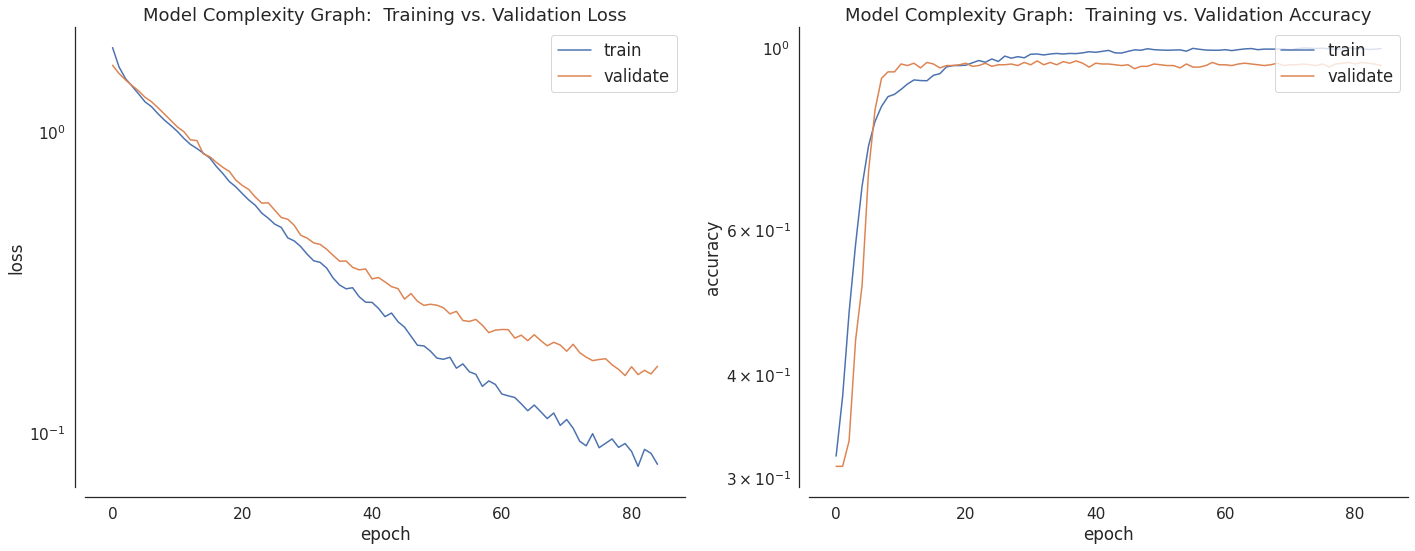

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

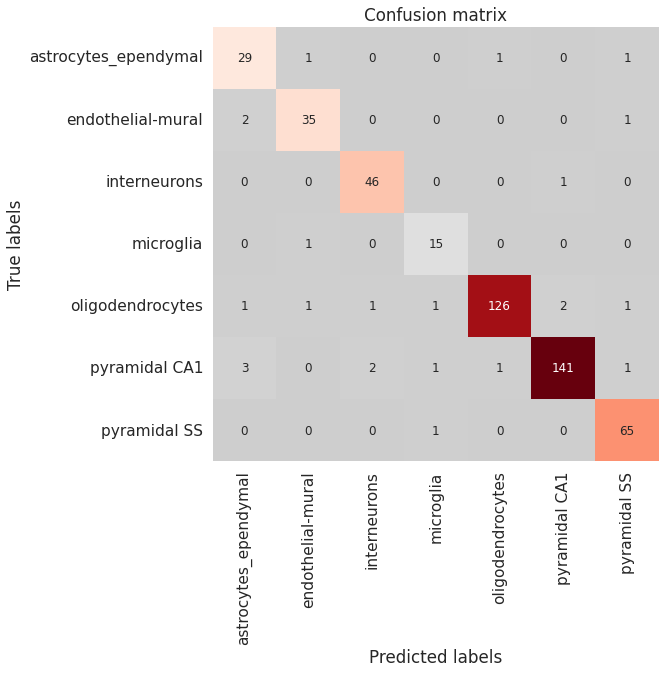

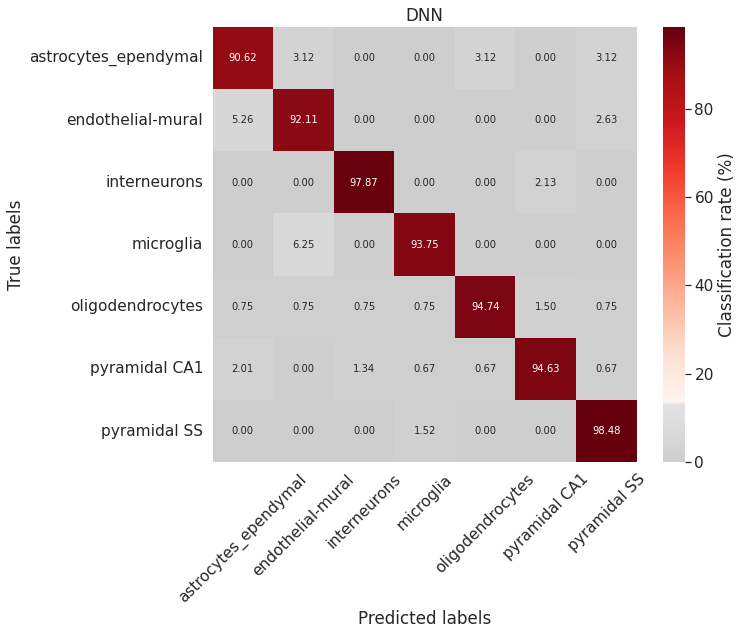

                      precision    recall  f1-score   support

astrocytes_ependymal       0.83      0.91      0.87        32
   endothelial-mural       0.92      0.92      0.92        38
        interneurons       0.94      0.98      0.96        47
           microglia       0.83      0.94      0.88        16
    oligodendrocytes       0.98      0.95      0.97       133
       pyramidal CA1       0.98      0.95      0.96       149
        pyramidal SS       0.94      0.98      0.96        66

            accuracy                           0.95       481
           macro avg       0.92      0.95      0.93       481
        weighted avg       0.95      0.95      0.95       481

16/16 [==============================] - 0s 1ms/step - loss: 0.1546 - accuracy: 0.9584 - auc: 0.9987 - precision: 0.9704 - recall: 0.9543


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


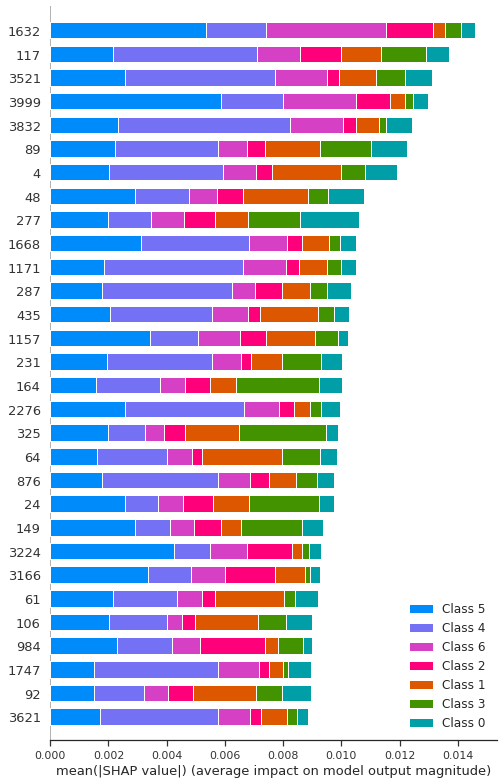

CPU times: user 6min 16s, sys: 17.4 s, total: 6min 33s
Wall time: 4min 2s


In [19]:
%%time
for tryy in range(1,num_times+1):
    # The smashpy methods set global seeds that mess with sampling. These seeds are used 
    # to stop those methods from using the same global seed over and over.
    np.random.seed(possible_seeds[seed_index])
    seed_index += 1
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    train_X_y = adata[np.concatenate([train_indices, val_indices]), :]
    sm = smashpy.smashpy()
    sm.DNN(train_X_y, group_by="annotation", model=None, balance=True, verbose=True, save=False)
    selectedGenes, selectedGenes_dict = sm.run_shap(train_X_y, group_by="annotation", model=None, verbose=True, pct=0.1, restrict_top=("global", k))
    # since this selects k per class, need select randomly from each classes
    smash_markers = adata.var.index.get_indexer(selectedGenes)

    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = smash_markers)
    np.save(model_save_path + 'smash_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'smash_markers_{}.npy'.format(tryy), smash_markers)
    np.save(model_save_path + 'experiment_data_folds/smash_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Smash Marker Visualization', path = viz_save_path + 'smash_markers_{}.png'.format(tryy), markers = smash_markers)

In [20]:
# The smashpy methods set global seeds that mess with sampling. These seeds are used 
# to stop those methods from using the same global seed over and over.
np.random.seed(possible_seeds[seed_index])
seed_index += 1

## Train RankCorr

In [21]:
for tryy in range(1,num_times+1):
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    data = Rocks(X_train, y_train)
    lamb = 4.7# this can be whatever

    rankcorr_markers = data.CSrankMarkers(lamb=lamb, writeOut=False, keepZeros=False, onlyNonZero=False)
    if len(rankcorr_markers) < k:
        raise Exception("Increase lamb for rank corr procedure")
    if len(rankcorr_markers) > k:
        rankcorr_markers = rankcorr_markers[:k]
    geneNames = np.array(adata.var.index)
    data.genes = geneNames
    marker_genes = data.markers_to_genes(rankcorr_markers)
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = rankcorr_markers)
    np.save(model_save_path + 'rankcorr_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'rankcorr_markers_{}.npy'.format(tryy), rankcorr_markers)
    np.save(model_save_path + 'experiment_data_folds/rankcorr_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'RankCorr Marker Visualization', path = viz_save_path + 'rankcorr_markers_{}.png'.format(tryy), markers = rankcorr_markers)

## Train L1 VAE

In [22]:
feature_std = torch.tensor(X).std(dim = 0)
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    model = VAE_l1_diag(input_size, hidden_layer_size, z_size, batch_norm = batch_norm)
    tmp_path = model_save_path + 'l1_vae_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, min_epochs = 25, 
                     max_epochs = 100, auto_lr = True, early_stopping_patience = 4, precision = precision)
    l1_markers = model.markers(feature_std = feature_std.to(model.device), k = k).clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = l1_markers)
    np.save(model_save_path + 'l1_vae_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'l1_vae_markers_{}.npy'.format(tryy), l1_markers)
    np.save(model_save_path + 'experiment_data_folds/l1_vae_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'L1 VAE Marker Visualization', path = viz_save_path + 'l1_vae_markers_{}.png'.format(tryy), markers = l1_markers)

`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:02<00:00, 43.97it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:02<00:00, 41.30it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:02<00:00, 40.02it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
`trainer.tune(train

## Train Global Gate

In [23]:
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers=num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    model = VAE_Gumbel_GlobalGate(input_size, hidden_layer_size, z_size, k = k, t = global_t, bias = True, temperature_decay=0.95, batch_norm = batch_norm)
    tmp_path = model_save_path + 'globalgate_vae_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus = gpus, tpu_cores = tpu_cores, 
                     min_epochs = 25, max_epochs = 100, auto_lr = True, max_lr = 0.00001, early_stopping_patience =  10, 
                     lr_explore_mode = 'linear', num_lr_rates = 500, precision = precision)
    globalgate_markers = model.markers().clone().cpu().detach().numpy()
    
 
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = globalgate_markers)
    np.save(model_save_path + 'globalgate_vae_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'globalgate_vae_markers_{}.npy'.format(tryy), globalgate_markers)
    np.save(model_save_path + 'experiment_data_folds/globalgate_vae_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Global Gate VAE Marker Visualization', path = viz_save_path + 'globalgate_vae_markers_{}.png'.format(tryy), markers = globalgate_markers)

`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:03<00:00, 29.48it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:04<00:00, 24.91it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:04<00:00, 24.52it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
`trainer.tune(train

## Train MarkerMap Unsupervised

In [24]:
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    model = MarkerMap(input_size, hidden_layer_size, z_size, k = k, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95, batch_norm = batch_norm, loss_tradeoff = 1.0, num_classes = None)
    tmp_path = model_save_path + 'marker_map_unsupervised_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=1, min_epochs = 25, max_epochs = 100, auto_lr = True, max_lr = 0.0001, early_stopping_patience = 4, 
                     lr_explore_mode = 'linear', num_lr_rates = 500, precision = precision)
    unsupervised_markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = unsupervised_markers)
    np.save(model_save_path + 'marker_map_unsupervised_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'marker_map_unsupervised_markers_{}.npy'.format(tryy), unsupervised_markers)
    np.save(model_save_path + 'experiment_data_folds/marker_map_unsupervised_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Marker Map Unsupervised Marker Visualization', path = viz_save_path + 'marker_map_unsupervised_markers_{}.png'.format(tryy), markers = unsupervised_markers)

`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:04<00:00, 24.03it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:04<00:00, 24.38it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:04<00:00, 24.25it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
`trainer.tune(train

## Train MarkerMap Supervised

In [25]:
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    
    model = MarkerMap(input_size, hidden_layer_size, z_size, num_classes = len(encoder.classes_), 
                             k = k, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95, batch_norm = batch_norm, loss_tradeoff = 0)
    tmp_path = model_save_path + 'marker_map_supervised_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, 
                     min_epochs = 25, max_epochs = 100, auto_lr = True, early_stopping_patience = 3, precision = precision, lr_explore_mode = 'linear', num_lr_rates=500)
    markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = markers)
    np.save(model_save_path + 'marker_map_supervised_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'marker_map_supervised_markers_{}.npy'.format(tryy), markers)
    np.save(model_save_path + 'experiment_data_folds/marker_map_supervised_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'MarkerMap Supervised Marker Visualization', path = viz_save_path + 'marker_map_supervised_markers_{}.png'.format(tryy), markers = markers)

`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:03<00:00, 26.02it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:03<00:00, 25.25it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:03<00:00, 25.36it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
`trainer.tune(train

## MakerMap Mixed

In [26]:
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    
    model = MarkerMap(input_size, hidden_layer_size, z_size, num_classes = len(encoder.classes_), 
                             k = k, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95, batch_norm = batch_norm, loss_tradeoff = 0.5)
    tmp_path = model_save_path + 'marker_map_mixed_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, 
                     min_epochs = 25, max_epochs = 100, auto_lr = True, early_stopping_patience = 3, precision = precision, lr_explore_mode = 'linear', num_lr_rates=500)
    markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = markers)
    np.save(model_save_path + 'marker_map_mixed_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'marker_map_mixed_markers_{}.npy'.format(tryy), markers)
    np.save(model_save_path + 'experiment_data_folds/marker_map_mixed_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'MarkerMap Mixed Supervision Marker Visualization', path = viz_save_path + 'marker_map_mixed_markers_{}.png'.format(tryy), markers = markers)

`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:04<00:00, 22.79it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:04<00:00, 22.62it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:04<00:00, 23.17it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
`trainer.tune(train

## Concrete VAE

In [27]:
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    model = ConcreteVAE_NMSL(input_size, hidden_layer_size, z_size, k = k, t = global_t, bias = True, temperature_decay = 0.9, batch_norm = batch_norm)
    tmp_path = model_save_path + 'concrete_vae_{}.ckpt'.format(tryy)
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=1, min_epochs = 25, max_epochs = 100, auto_lr = True, max_lr = 0.0001, early_stopping_patience = 3, 
                     lr_explore_mode = 'linear', num_lr_rates = 500, precision = precision)
    concrete_vae_markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = concrete_vae_markers)
    np.save(model_save_path + 'concrete_vae_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'concrete_vae_markers_{}.npy'.format(tryy), concrete_vae_markers)
    np.save(model_save_path + 'experiment_data_folds/concrete_vae_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Concrete VAE Marker Visualization', path = viz_save_path + 'concrete_vae_markers_{}.png'.format(tryy), markers = concrete_vae_markers)

`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:02<00:00, 36.66it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:02<00:00, 36.69it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:02<00:00, 33.67it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
`trainer.tune(train

## LassoNet



In [28]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [29]:
from functools import partial
from lassonet import plot_path

In [30]:
for tryy in range(1,num_times+1):  
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    X_train = X[train_indices, :]
    y_train = y[train_indices]
    X_val = X[val_indices,:]
    y_val = y[val_indices]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    model = LassoNetClassifier()
    model.path(X_train, y_train, X_val = X_val, y_val = y_val)
    lasso_net_markers = torch.argsort(model.feature_importances_, descending = True).cpu().numpy()[:k]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = lasso_net_markers)
    np.save(model_save_path + 'lasso_net_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'lasso_net_markers_{}.npy'.format(tryy), lasso_net_markers)
    np.save(model_save_path + 'experiment_data_folds/lasso_net_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'LassoNet Marker Visualization', path = viz_save_path + 'lasso_net_markers_{}.png'.format(tryy), markers = lasso_net_markers)

## Get Model Metrics from KNNs Classifiers

The above just generates metrics for the Random Forests.

In [31]:
from sklearn.neighbors import KNeighborsClassifier

In [32]:
def generate_metrics_from_saved_files(X, y, folds_path, markers_path, classifier_model, save_path):
    train_indices, val_indices, test_indices = np.load(folds_path, allow_pickle = True)
    markers = np.load(markers_path, allow_pickle = True)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices, :]
    y_test = y[test_indices]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = markers, model = classifier_model)

    np.save(save_path, results)
    return

def batch_generate_metrics_from_saved_files(X, y, format_folds_path, format_markers_path, format_save_path):
    for tryy in range(1, num_times+1):
        classifier_model = KNeighborsClassifier()
        generate_metrics_from_saved_files(X, y, format_folds_path.format(tryy), format_markers_path.format(tryy), classifier_model, format_save_path.format(tryy))
    return

In [33]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/all_markers_indices_{}.npy',
                                  model_save_path+'all_markers_{}.npy',
                                  model_save_path+'all_markers_knn_results_{}.npy')


In [34]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/l1_vae_indices_{}.npy',
                                  model_save_path+'l1_vae_markers_{}.npy',
                                  model_save_path+'l1_vae_knn_results_{}.npy')

batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/smash_rf_indices_{}.npy',
                                  model_save_path+'smash_rf_markers_{}.npy',
                                  model_save_path+'smash_rf_knn_results_{}.npy')

batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/smash_indices_{}.npy',
                                  model_save_path+'smash_markers_{}.npy',
                                  model_save_path+'smash_knn_results_{}.npy')

batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/rankcorr_indices_{}.npy',
                                  model_save_path+'rankcorr_markers_{}.npy',
                                  model_save_path+'rankcorr_knn_results_{}.npy')

batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/globalgate_vae_indices_{}.npy',
                                  model_save_path+'globalgate_vae_markers_{}.npy',
                                  model_save_path+'globalgate_vae_knn_results_{}.npy')

batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/marker_map_unsupervised_indices_{}.npy',
                                  model_save_path+'marker_map_unsupervised_markers_{}.npy',
                                  model_save_path+'marker_map_unsupervised_knn_results_{}.npy')


batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/marker_map_supervised_indices_{}.npy',
                                  model_save_path+'marker_map_supervised_markers_{}.npy',
                                  model_save_path+'marker_map_supervised_knn_results_{}.npy')


batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/concrete_vae_indices_{}.npy',
                                  model_save_path+'concrete_vae_markers_{}.npy',
                                  model_save_path+'concrete_vae_knn_results_{}.npy')

In [35]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/marker_map_mixed_indices_{}.npy',
                                  model_save_path+'marker_map_mixed_markers_{}.npy',
                                  model_save_path+'marker_map_mixed_knn_results_{}.npy')

In [36]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/lasso_net_indices_{}.npy',
                                  model_save_path+'lasso_net_markers_{}.npy',
                                  model_save_path+'lasso_net_knn_results_{}.npy')

# Results and Visualizations

## Accuracies and F1

In [37]:
result_axis = [
 ('All Markers', 'all_markers_results_{}.npy', 'all_markers_knn_results_{}.npy'), 
 ('L1 VAE', 'l1_vae_results_{}.npy', 'l1_vae_knn_results_{}.npy'),
 ('Smash RF', 'smash_rf_results_{}.npy', 'smash_rf_knn_results_{}.npy'),
 ('SMaSH DNN', 'smash_results_{}.npy', 'smash_knn_results_{}.npy'),
 ('RankCorr', 'rankcorr_results_{}.npy', 'rankcorr_knn_results_{}.npy'),
 ('Global Gate VAE', 'globalgate_vae_results_{}.npy', 'globalgate_vae_knn_results_{}.npy'),
 ('MarkerMap Unsupervised', 'marker_map_unsupervised_results_{}.npy', 'marker_map_unsupervised_knn_results_{}.npy'),
 ('MarkerMap Supervised', 'marker_map_supervised_results_{}.npy', 'marker_map_supervised_knn_results_{}.npy'),
 ('MarkerMap Mixed Supervision', 'marker_map_mixed_results_{}.npy', 'marker_map_mixed_knn_results_{}.npy'),
 ('Concrete VAE',  'concrete_vae_results_{}.npy', 'concrete_vae_knn_results_{}.npy'),
 ('LassoNet', 'lasso_net_results_{}.npy', 'lasso_net_knn_results_{}.npy')
]

In [38]:
data_proto = []
indices = []
for axis in result_axis: 
    data_proto.append(model_variances(model_save_path + axis[1], num_times))
    indices.append(axis[0])

In [39]:
pd.DataFrame(data_proto, index = indices, 
             columns = ['Misclassification Mean', 'Weighted F1 Mean', 'Misclassification Standard Deviation', 'Weighted F1 Standard Deviation'])

Misclassification Mean  Weighted F1 Mean  \
All Markers                                0.046256          0.952988   
L1 VAE                                     0.207321          0.776945   
Smash RF                                   0.047255          0.952158   
SMaSH DNN                                  0.081697          0.915336   
RankCorr                                   0.049750          0.949432   
Global Gate VAE                            0.206822          0.778966   
MarkerMap Unsupervised                     0.114309          0.879059   
MarkerMap Supervised                       0.047088          0.952175   
MarkerMap Mixed Supervision                0.069717          0.927078   
Concrete VAE                               0.227454          0.755629   
LassoNet                                   0.050416          0.948475   

                             Misclassification Standard Deviation  \
All Markers                                              0.005304   
L1 VAE                                                   0.045386   
Smash RF                                                 0.009120   
SMaSH DNN                                                0.041306   
RankCorr                                                 0.006798   
Global Gate VAE                                          0.027341   
MarkerMap Unsupervised                                   0.041351   
MarkerMap Supervised                                     0.007061   
MarkerMap Mixed Supervision                              0.008628   
Concrete VAE                                             0.038393   
LassoNet                                                 0.005620   

                             Weighted F1 Standard Deviation  
All Markers                                        0.005562  
L1 VAE                                             0.053125  
Smash RF                                           0.009239  
SMaSH DNN                                          0.044366  
RankCorr                                           0.007030  
Global Gate VAE                                    0.030386  
MarkerMap Unsupervised                             0.046196  
MarkerMap Supervised                               0.007283  
MarkerMap Mixed Supervision                        0.010258  
Concrete VAE                                       0.045483  
LassoNet                                           0.005877

In [40]:
data_proto = []
indices = []
for axis in result_axis: 
    data_proto.append(model_variances(model_save_path + axis[2], num_times))
    indices.append(axis[0])

In [41]:
pd.DataFrame(data_proto, index = indices, 
             columns = ['Misclassification Mean', 'Weighted F1 Mean', 'Misclassification Standard Deviation', 'Weighted F1 Standard Deviation'])

Misclassification Mean  Weighted F1 Mean  \
All Markers                                0.055574          0.943922   
L1 VAE                                     0.283195          0.700684   
Smash RF                                   0.046423          0.953228   
SMaSH DNN                                  0.104160          0.892803   
RankCorr                                   0.048918          0.950171   
Global Gate VAE                            0.282862          0.703148   
MarkerMap Unsupervised                     0.151913          0.839751   
MarkerMap Supervised                       0.043095          0.956532   
MarkerMap Mixed Supervision                0.073378          0.923780   
Concrete VAE                               0.303328          0.679870   
LassoNet                                   0.054908          0.943510   

                             Misclassification Standard Deviation  \
All Markers                                              0.008226   
L1 VAE                                                   0.044403   
Smash RF                                                 0.007641   
SMaSH DNN                                                0.066047   
RankCorr                                                 0.006145   
Global Gate VAE                                          0.033069   
MarkerMap Unsupervised                                   0.062784   
MarkerMap Supervised                                     0.006998   
MarkerMap Mixed Supervision                              0.011539   
Concrete VAE                                             0.032265   
LassoNet                                                 0.006530   

                             Weighted F1 Standard Deviation  
All Markers                                        0.008324  
L1 VAE                                             0.046442  
Smash RF                                           0.007805  
SMaSH DNN                                          0.066720  
RankCorr                                           0.006124  
Global Gate VAE                                    0.033498  
MarkerMap Unsupervised                             0.067981  
MarkerMap Supervised                               0.007091  
MarkerMap Mixed Supervision                        0.012096  
Concrete VAE                                       0.036486  
LassoNet                                           0.006822

## Confusion Matrices

k = 50

### All Marker Baseline

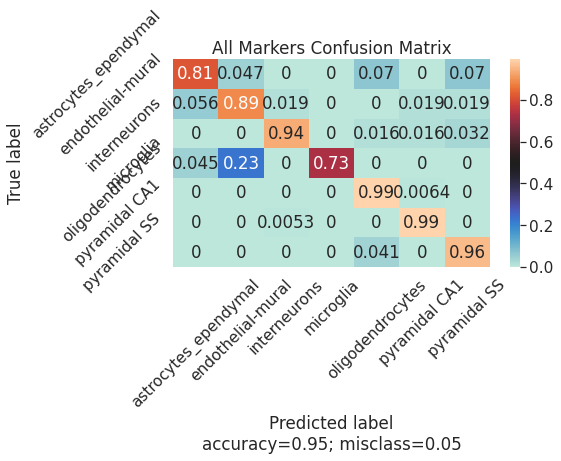

In [42]:
results =  np.load(model_save_path + 'all_markers_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'All Markers Confusion Matrix', save_path = viz_save_path + 'all_markers_cm.pdf', cmap = 'icefire')

### Smash RF

In [43]:
results =  np.load(model_save_path + 'smash_rf_results_{}.npy'.format(1), allow_pickle = True)

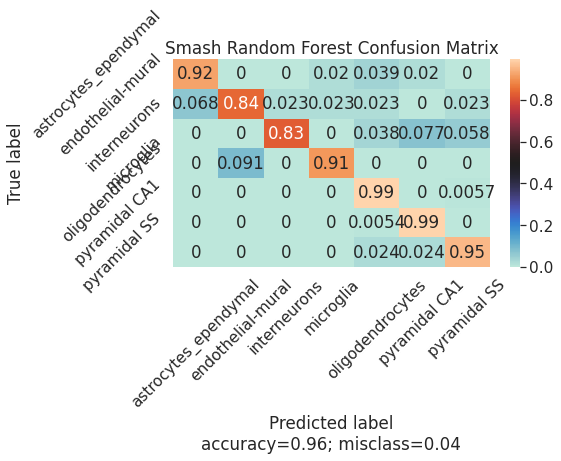

In [44]:
plot_confusion_matrix(results[2], encoder.classes_, title = 'Smash Random Forest Confusion Matrix', save_path = viz_save_path + 'smash_rf_cm.pdf', cmap = 'icefire')

### Smash DNN

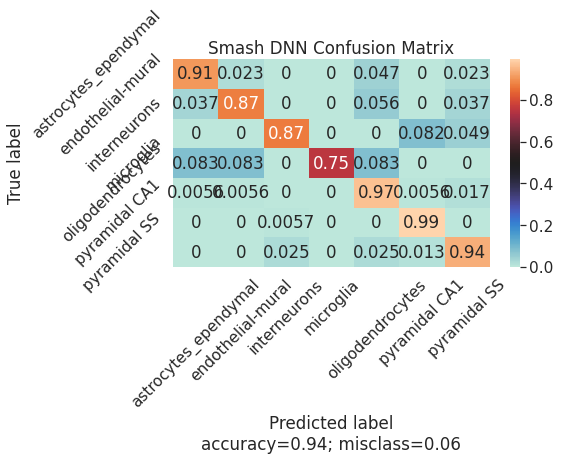

In [45]:
results =  np.load(model_save_path + 'smash_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'Smash DNN Confusion Matrix', save_path = viz_save_path + 'smash_cm.pdf', cmap = 'icefire')

### RankCorr

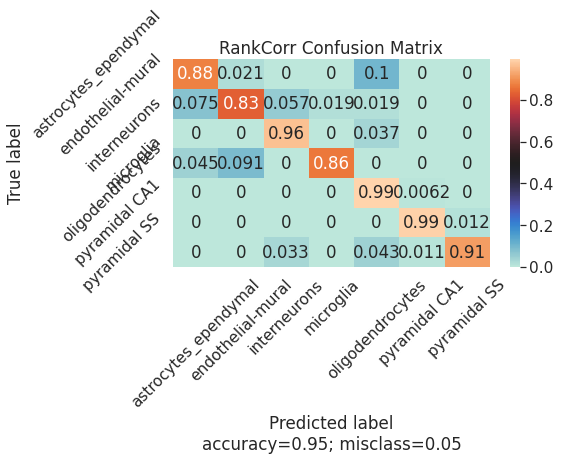

In [46]:
results =  np.load(model_save_path + 'rankcorr_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'RankCorr Confusion Matrix', save_path = viz_save_path + 'rankcorr_cm.pdf', cmap = 'icefire')

### L1 VAE

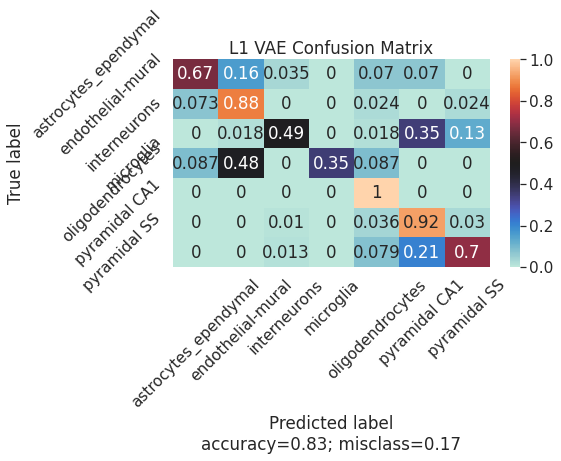

In [47]:
results =  np.load(model_save_path + 'l1_vae_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'L1 VAE Confusion Matrix', save_path = viz_save_path + 'l1_vae_cm.pdf', cmap = 'icefire')

### Global Gate VAE

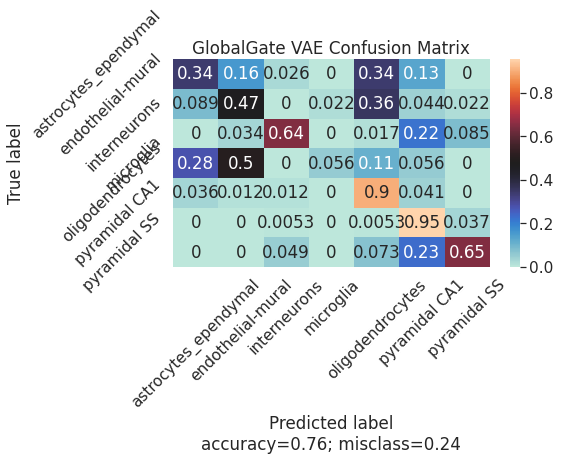

In [48]:
results =  np.load(model_save_path + 'globalgate_vae_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'GlobalGate VAE Confusion Matrix', save_path = viz_save_path + 'globalgate_vae_cm.pdf', cmap = 'icefire')

### MarkerMap Unsupervised

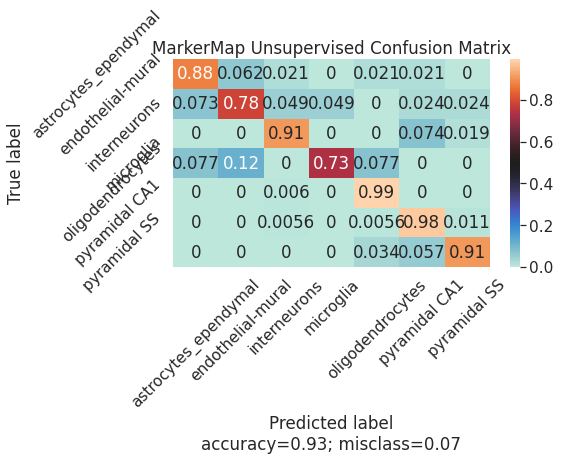

In [49]:
results =  np.load(model_save_path + 'marker_map_unsupervised_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'MarkerMap Unsupervised Confusion Matrix', save_path = viz_save_path + 'marker_map_unsupervised_cm.pdf', cmap = 'icefire')

### MarkerMap Supervised


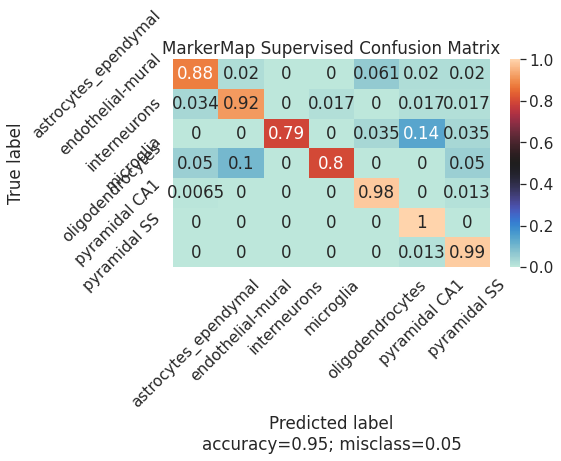

In [50]:
results =  np.load(model_save_path + 'marker_map_supervised_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'MarkerMap Supervised Confusion Matrix', save_path = viz_save_path + 'marker_map_supervised_cm.pdf', cmap = 'icefire')

## MarkerMap Mixed Supervision

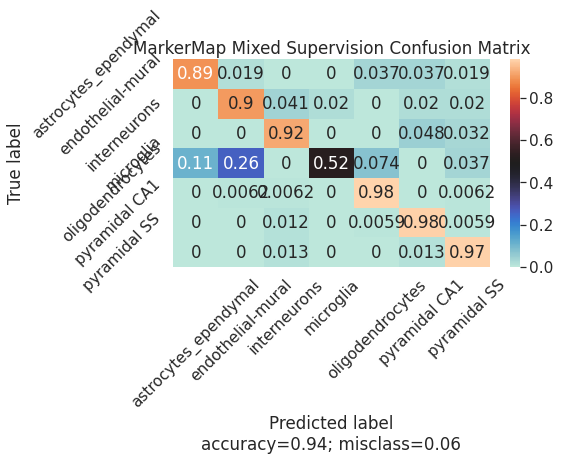

In [51]:
results =  np.load(model_save_path + 'marker_map_mixed_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'MarkerMap Mixed Supervision Confusion Matrix', save_path = viz_save_path + 'marker_map_mixed_cm.pdf', cmap = 'icefire')

### Concrete VAE

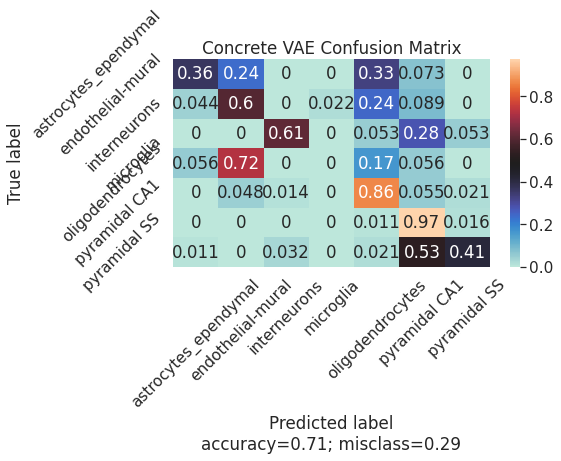

In [52]:
results =  np.load(model_save_path + 'concrete_vae_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'Concrete VAE Confusion Matrix', save_path = viz_save_path + 'concrete_vae_cm.pdf', cmap = 'icefire')

## LassoNet

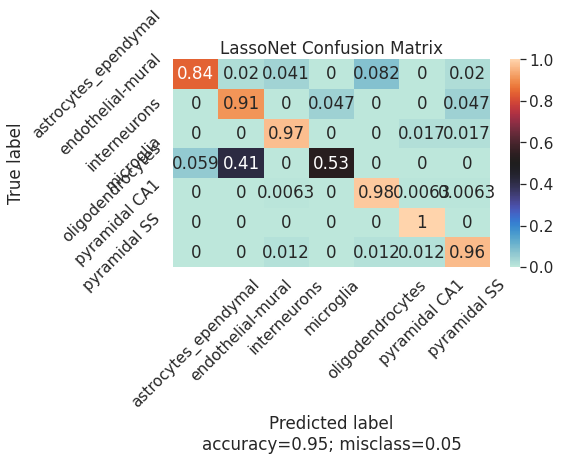

In [53]:
results =  np.load(model_save_path + 'lasso_net_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'LassoNet Confusion Matrix', save_path = viz_save_path + 'lasso_net_cm.pdf', cmap = 'icefire')